## Auto-regressive approach:  Par Produit/Magasin ou Bottom-Top


pip install dataenforce
pip install -U google-cloud-secret-manager
pip install google-cloud-secret-manager
pip install google-cloud-storage==1.42.2

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os 
os.environ["ENV"]="LOCAL"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../store_order_service_account"
#print(os.environ) 
#os.chdir("/Users/gnabeyeuemmanuel/Desktop/demandEstimate/demand-service")

import sys
#sys.path.append("../")

In [3]:
os.getcwd()

'/content'

In [4]:

import os
import sys
import sys; 
sys.path.insert(0, '..')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
from sklearn.cluster import KMeans
#import pandasgui
%matplotlib inline
#import google.cloud.secretmanager as secretmanager

#from utils.utility_fct import get_table_sql,cross_product

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline

import time
import datetime
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA, NMF,FastICA,TruncatedSVD,IncrementalPCA
#from french_holidays import get_french_holiday_calendar

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

In [6]:
#sql_querry = """
#select * from api_storebox.products_view where products_view_date>date('2022-01-01')
#"""
#data = get_table_sql(sql_querry)

## Load and Plot the time series dataset

In [7]:
from google.colab import files 
#uploaded = files.upload()
import pandas as pd 
import io 
  
#df = pd.read_csv(io.BytesIO(uploaded['demande.csv'])) 
#print(df)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
path = '/content/drive/MyDrive/Data/demande.csv'
series = pd.read_csv(path)
series.head()

product_id                  store_id        date  \
0  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-03   
1  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-05   
2  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-09   
3  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-10   
4  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-13   

   product_count  
0              1  
1              1  
2              2  
3              1  
4              2

In [10]:
''' Décommenter en local
# load dataset
series = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/demande.csv', header=0) #index_col=0
print(values)
#visualize
series.head()'''


" Décommenter en local\n# load dataset\nseries = pd.read_csv('/Users/gnabeyeuemmanuel/Desktop/demande.csv', header=0) #index_col=0\nprint(values)\n#visualize\nseries.head()"

In [11]:
#series.describe()
series.columns

Index(['product_id', 'store_id', 'date', 'product_count'], dtype='object')

In [12]:
series2 = pd.read_csv('/content/drive/MyDrive/Data/product_movements.csv', header=0) 
print(series2.columns)
series2.tail()

Index(['store_id', 'product_id', 'start_date', 'end_date'], dtype='object')


store_id                product_id  \
10012  627e47501f5ac0001658172d  62728f8fe2e13b00164caa25   
10013  627e47501f5ac0001658172d  62728f8fe2e13b00164caa28   
10014  627e47501f5ac0001658172d  6275397c7ea2640016504019   
10015  627e47501f5ac0001658172d  62860141dc844500166fca19   
10016  627e47501f5ac0001658172d                       NaN   

                          start_date                       end_date  
10012  2022-05-20 00:02:44.895 +0200  2022-06-17 14:17:40.263 +0200  
10013  2022-05-20 00:02:44.895 +0200  2022-06-17 14:17:40.263 +0200  
10014  2022-06-04 01:20:53.741 +0200  2022-06-17 14:17:40.263 +0200  
10015  2022-06-04 01:20:53.741 +0200  2022-06-17 14:17:40.263 +0200  
10016  2022-05-19 00:00:00.000 +0200  2022-05-19 00:00:00.000 +0200

In [13]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df1=pd.DataFrame() 
    #début à partir du 1er janvier 2022   .strftime('%Y-%m-%d')
    ref=datetime.datetime(2022,1,1)
    indexNames = df[df['end_date'] < ref].index
    df.drop(indexNames , inplace=True)
    for i in df.index:
        if df['start_date'][i] < ref:
            df['start_date'][i] = ref
            
    #Dates intermédiaires sur la présence des produits dans le magassin
    df["date"] = df.apply(lambda x: pd.date_range(x.start_date, x.end_date), axis=1)
    df = df.explode('date').reset_index(drop=True)
    df['date']=df['date'].dt.date
        
    return df

In [14]:
import datetime
series2['start_date']= pd.to_datetime(series2['start_date'],utc=True).dt.tz_localize(None)
series2['end_date']= pd.to_datetime(series2['end_date'],utc=True).dt.tz_localize(None)

df_pro=preprocess(series2)
df_pro

store_id                product_id  \
0        5d5d24216115b3000435fa24  5cebfa8d0b259700045dc8a9   
1        5d5d24216115b3000435fa24  5cebfa8d0b259700045dc8a9   
2        5d5d24216115b3000435fa24  5cebfa8d0b259700045dc8a9   
3        5d5d24216115b3000435fa24  5cebfa8d0b259700045dc8a9   
4        5d5d24216115b3000435fa24  5cebfa8d0b259700045dc8a9   
...                           ...                       ...   
1024943  627e47501f5ac0001658172d  62860141dc844500166fca19   
1024944  627e47501f5ac0001658172d  62860141dc844500166fca19   
1024945  627e47501f5ac0001658172d  62860141dc844500166fca19   
1024946  627e47501f5ac0001658172d  62860141dc844500166fca19   
1024947  627e47501f5ac0001658172d                       NaN   

                     start_date                end_date        date  
0       2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  2022-01-01  
1       2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  2022-01-02  
2       2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  2022-01-03  
3       2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  2022-01-04  
4       2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  2022-01-05  
...                         ...                     ...         ...  
1024943 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  2022-06-13  
1024944 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  2022-06-14  
1024945 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  2022-06-15  
1024946 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  2022-06-16  
1024947 2022-05-18 22:00:00.000 2022-05-18 22:00:00.000  2022-05-18  

[1024948 rows x 5 columns]

In [15]:
series['date'] = pd.to_datetime(series.date).dt.date
series3=series.merge(df_pro, how='right', on=['date','store_id','product_id']).fillna({'product_count':0})
series3

product_id                  store_id        date  \
0        5cebfa8d0b259700045dc8a9  5d5d24216115b3000435fa24  2022-01-01   
1        5cebfa8d0b259700045dc8a9  5d5d24216115b3000435fa24  2022-01-02   
2        5cebfa8d0b259700045dc8a9  5d5d24216115b3000435fa24  2022-01-03   
3        5cebfa8d0b259700045dc8a9  5d5d24216115b3000435fa24  2022-01-04   
4        5cebfa8d0b259700045dc8a9  5d5d24216115b3000435fa24  2022-01-05   
...                           ...                       ...         ...   
1024943  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-13   
1024944  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-14   
1024945  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-15   
1024946  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-16   
1024947                       NaN  627e47501f5ac0001658172d  2022-05-18   

         product_count              start_date                end_date  
0                  0.0 2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  
1                  0.0 2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  
2                  0.0 2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  
3                  0.0 2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  
4                  0.0 2022-01-01 00:00:00.000 2022-06-17 12:17:40.263  
...                ...                     ...                     ...  
1024943            0.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024944            0.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024945            0.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024946            0.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024947            0.0 2022-05-18 22:00:00.000 2022-05-18 22:00:00.000  

[1024948 rows x 6 columns]

In [16]:
boolean = any(series['store_id'].duplicated())
bool = any(series['product_count']==0)
print(boolean,bool)
print(series3['product_id'][50000])
print(series3['store_id'][50000])

True True
5f8ee80289bc4b000417840f
5f1198de8746ae00042869ba


In [17]:
b=series3[['product_id','store_id','product_count','date']].groupby(['product_id','store_id','date']).agg({ "product_count":sum})
c = b.query("(product_id == '5f8ee80289bc4b000417840f') & (store_id=='5f1198de8746ae00042869ba') ") 
#c=df_q

In [18]:
print(c['product_count'].to_numpy().max())

3.0


In [19]:
h=series3.query("(product_count > 0)") 
h

product_id                  store_id        date  \
32562    5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-03   
32564    5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-05   
32568    5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-09   
32569    5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-10   
32572    5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-13   
...                           ...                       ...         ...   
1024935  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-05   
1024936  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-06   
1024938  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-08   
1024939  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-09   
1024941  62860141dc844500166fca19  627e47501f5ac0001658172d  2022-06-11   

         product_count              start_date                end_date  
32562              1.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32564              1.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32568              2.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32569              1.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32572              2.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
...                ...                     ...                     ...  
1024935            1.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024936            2.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024938            1.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024939            1.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  
1024941            1.0 2022-06-03 23:20:53.741 2022-06-17 12:17:40.263  

[222164 rows x 6 columns]

In [20]:
df_q = series3.query("(product_id == '5cebfa8d0b259700045dc8aa') & (store_id=='5f1198de8746ae00042869ba') ") #.dropna({'product_count':0}) 
#df_q = series3.query("(product_id == '5cebfa8d0b259700045dc8ad') & (store_id=='5f1198de8746ae00042869ba') ") 
df_q 

product_id                  store_id        date  \
32561  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-02   
32562  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-03   
32563  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-04   
32564  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-05   
32565  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-02-06   
...                         ...                       ...         ...   
32691  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-06-12   
32692  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-06-13   
32693  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-06-14   
32694  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-06-15   
32695  5cebfa8d0b259700045dc8aa  5f1198de8746ae00042869ba  2022-06-16   

       product_count              start_date                end_date  
32561            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32562            1.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32563            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32564            1.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32565            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
...              ...                     ...                     ...  
32691            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32692            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32693            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32694            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  
32695            0.0 2022-02-02 15:00:31.344 2022-06-17 12:17:40.263  

[135 rows x 6 columns]

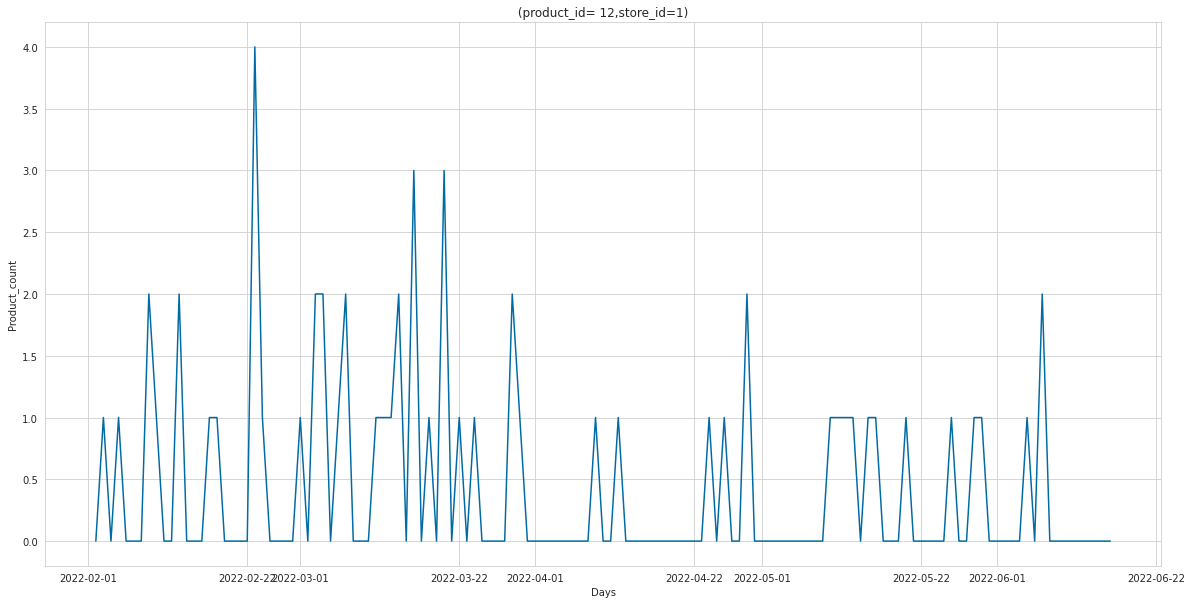

In [21]:
df_q = df_q.iloc[:,2:4].reset_index()
df_q=df_q.iloc[:,1:3].set_index('date')



plt.figure(figsize=(20,10))

plt.plot(df_q)
plt.title(" (product_id= 12,store_id=1) ")
plt.xlabel('Days')
plt.ylabel('Product_count')

plt.show()

In [22]:
def metrics_(orig,preds):
    MSE=mean_squared_error(y_true=orig,
                   y_pred=preds)
    MAE=mean_absolute_error(y_true=orig,
                   y_pred=preds)
    MSLE=mean_squared_log_error(y_true=np.abs(orig),
                   y_pred=np.abs(preds))
    metrics = dict()
    metrics['MSE']= MSE
    metrics['MAE']= MAE
    metrics['MSLE']= MSLE
    return metrics

#### Modele Simpliste: La Moyenne

In [184]:
#Référence = Moyenne des ventes sur cette période ?
import math
test_size=0.2
l=math.floor((1-test_size)*df_q.shape[0])
mean=df_q.reset_index().loc[:l, ['product_count']].mean()  
mean

product_count    0.477064
dtype: float64

In [186]:
res = df_q.reset_index().loc[l:]
res['product_count_predict']=mean[0]

sa_m=metrics_(res['product_count'],res['product_count_predict'])
metrics_hist15=pd.DataFrame([sa_m])
metrics_hist15['Model']='S.Average'
metrics_hist15.set_index('Model', inplace = True)
metrics_hist15

MSE       MAE      MSLE
Model                                  
S.Average  0.311858  0.522596  0.156173

In [25]:
# xgboost
import xgboost
print("xgboost", xgboost.__version__)

xgboost 0.90


##### XgBoost Rolling (Auto-regressive day by day)

In [26]:
# forecast monthly with xgboost
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    columns = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        columns.append(df.shift(i))
    # put it all together
    agg = pd.concat(columns, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
    

In [27]:
# split the dataset into train/test sets
def split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [28]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(data_train, data_test):
    # transform list into array
    data_train = np.asarray(data_train)
    # split into input and output columns
    X_train, y_train = data_train[:, :-1], data_train[:, -1]
    # fit the model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train, y_train)
    # make a one-step prediction
    y_predict = model.predict(np.asarray([data_test]))
    return y_predict[0]


In [29]:
# walk-forward validation for univariate data, predict day by day
def walk_forward_validation(data, n_val):
    predictions = list()
    # spliting
    train_set, test_set = split(data, n_val)
    # seed history with training dataset
    history = [x for x in train_set]
    # step over each time-step in the test set
    for i in range(len(test_set)):
        # split test_set row into input and output columns
        x, y = test_set[i, :-1], test_set[i, -1]
        # fit model on history and make a prediction
        y_predict = xgboost_forecast(history,x)
        # store forecast in list of predictions
        predictions.append(y_predict)
        # add actual observation to history for the next loop
        history.append(test_set[i])
        # summarize progress
        print('*** expected=%.1f, predicted=%.1f' % (y, y_predict))
    # estimate prediction error
    
    error = metrics_(test_set[:, -1], predictions)
    return error, test_set[:, -1], predictions

*** expected=1.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.6
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=1.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.5
*** expected=1.0, predicted=0.4
*** expected=1.0, predicted=0.4
*** expected=0.0, predicted=0.7
*** expected=0.0, predicted=0.5
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=1.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=2.0, predicted=0.5
*** expected=0.0, predicted=0.8
*** expected=0.0, predicted=0.8
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4
*** expected=0.0, predicted=0.4


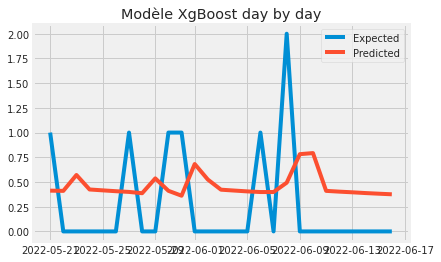

MSE       MAE      MSLE
Model                                               
Xgboost_roll(daybyday)  0.337735  0.535137  0.161505

In [187]:
# transform the time series data into supervised learning
ax=df_q.reset_index().loc[l:, ['date']]
values=df_q
data = series_to_supervised(values, n_in=3)
# evaluate
err, y, y_predict = walk_forward_validation(data, len(ax))

metrics_hist=pd.DataFrame([err])
metrics_hist['Model']='Xgboost_roll(daybyday)'
metrics_hist.set_index('Model', inplace = True)



# plot expected vs preducted
plt.plot(ax,y, label='Expected')
plt.plot(ax,y_predict, label='Predicted')
plt.legend()
plt.title('Modèle XgBoost day by day')
plt.savefig('XgBoost_plot.pdf') 
plt.show()
metrics_hist

##### Multi-Step Forecasting: Direct-Recursive Hybrid Strategies

1.prediction(t+1) = model1(obs(t-1), obs(t-2), ..., obs(t-n))

2.prediction(t+2) = model2(prediction(t+1), obs(t-1), ..., obs(t-n))

#### finalize model and make a prediction for monthly with xgboost

A new row of input is prepared using the last 6 days of known data and the 2 next days beyond the end of the dataset is predicted.

In [31]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

# transform the time series data into supervised learning
train_set = series_to_supervised(values, n_in=6)
# split into input and output columns
X_train, y_train = train_set[:, :-1], train_set[:, -4:-1]
print(X_train.shape, y_train.shape)
# define base model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# define the direct multioutput wrapper model
wrapper =  RegressorChain(model) # or wrapper=MultiOutputRegressor(model)
# fit model on the whole data
wrapper.fit(X_train, y_train)

# construct an input for a new preduction
row = values[-5:] #.flatten()
row=np.asarray([row]).flatten()
# make a one-step prediction
y_prec = wrapper.predict(np.asarray([row]))
# summarize the prediction
print('Input: %s, Predicted: %s' % (row, y_prec[0]))

(129, 5) (129, 3)
Input: [0. 0. 0. 0. 0.], Predicted: [5.64157963e-05 5.64157963e-05 5.44488430e-05]


**Problem:** this does not seem to account for things that time-series models are designed to address, such as seasonality, whether the data is stationary or not

In [32]:
from xgboost import plot_importance, plot_tree

data = series_to_supervised(values, n_in=2)
#split
data_train, data_test = split(data, len(ax))
# split into input and output columns
X_train, y_train = data_train[:, :-1], data_train[:, -1]
X_test, y_test = data_test[:, :-1], data_test[:, -1]

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[10:26:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

#### Regression linéaire

In [33]:
##tendance:  on l’obtient en réalisant une régression linéaire de Y sur le temps t.
from statsmodels.api import OLS

y = df_q['product_count']
X = np.ones((len(y), 2))
X[:,1] = np.arange(0,len(y))
reg = OLS(y,X)
results = reg.fit()
results.params

const    0.689760
x1      -0.003883
dtype: float64

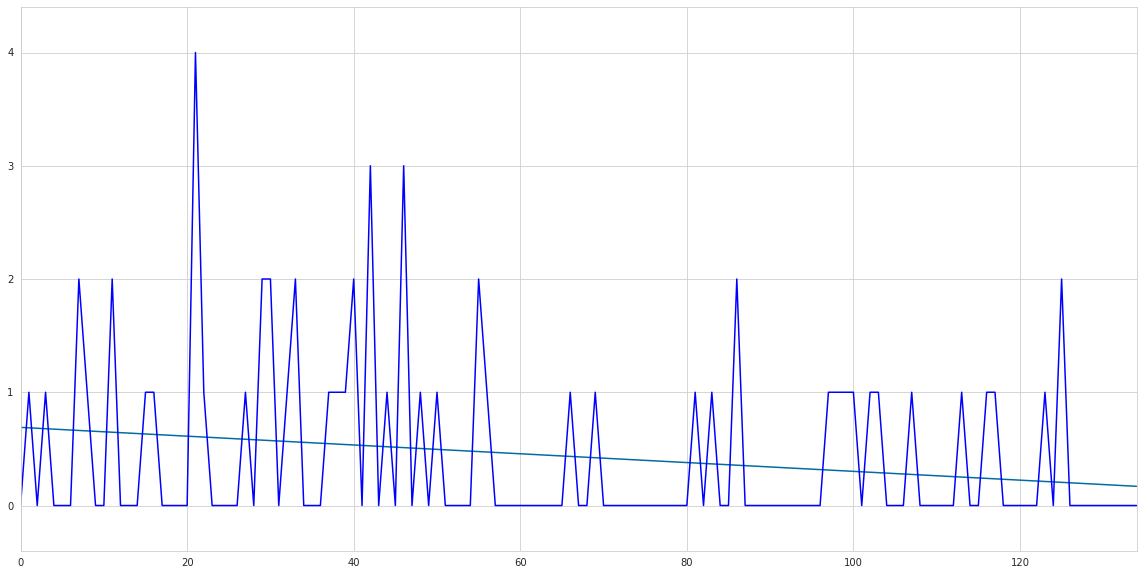

In [34]:
from statsmodels.graphics.regressionplots import abline_plot
fig = abline_plot(model_results=results)
ax = fig.axes[0]
ax.plot(X[:,1], y, 'b')
ax.margins(.1)

#### Modèle Auto-régressif
Partir du principe que les valeurs passées ont un effet sur les valeurs actuelles

##### MA

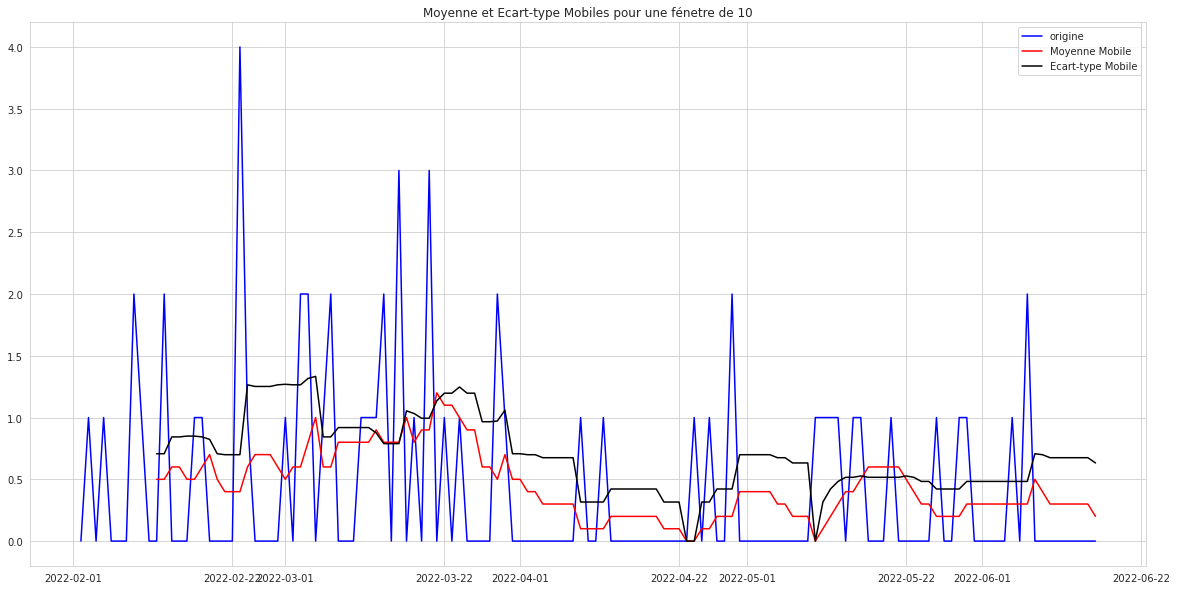

In [35]:
rolling_mean=df_q.rolling(window=10,axis=0).mean().shift(1)
rolling_std=df_q.rolling(window=10,axis=0).std().shift(1)
plt.plot(df_q, color='blue', label='origine')
plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
plt.legend(loc='best')
plt.title('Moyenne et Ecart-type Mobiles pour une fénetre de 10')

plt.savefig('Mobil_Average_plot.pdf')  
plt.show()

In [36]:
err_rolling=metrics_(rolling_mean.fillna(0),df_q)
metrics_hist3=pd.DataFrame([err_rolling])
metrics_hist3['Model']='Rolling or MA'
metrics_hist3.set_index('Model', inplace = True)
metrics_hist3

MSE       MAE      MSLE
Model                                      
Rolling or MA  0.582741  0.568148  0.194343

on met en œuvre les méthodes pour vériﬁer la stationnarité, c’est-à-dire le test de Dickey-Fuller et le test de 
p-valeur. On utilise pour cela la méthode adfuller de statsmodels.tsa.stattools :

In [37]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_q)
print('ADF Stats : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical values :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Stats : -11.659822310424792
p-value : 1.945490463402753e-21
Critical values :
	1%: -3.480118600110386
	5%: -2.8833618426136196
	10%: -2.578407034974382


#### Autoregressive Moving Average (ARMA)
**Number of AR** (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
**Number of MA** (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.


In [38]:
'''
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(df_q, order=(2, 1))
model_fit = model.fit(disp=False)

model_fit.summary()

'''

'\n# ARMA example\nfrom statsmodels.tsa.arima_model import ARMA\nfrom random import random\n\n# fit model\nmodel = ARMA(df_q, order=(2, 1))\nmodel_fit = model.fit(disp=False)\n\nmodel_fit.summary()\n\n'

### Arima

In [39]:
#!pip install statsmodels==0.12.1

In [40]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

train=df_q.loc[:datetime.date(2022,5,20)]
arima_mod = ARIMA(train, order=(0, 0, 0)) ##see below for order
model = arima_mod.fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          product_count   No. Observations:                  108
Model:                          ARIMA   Log Likelihood                -127.434
Date:                Wed, 06 Jul 2022   AIC                            258.868
Time:                        10:26:37   BIC                            264.232
Sample:                    02-02-2022   HQIC                           261.043
                         - 05-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4815      0.122      3.961      0.000       0.243       0.720
sigma2         0.6200      0.080      7.794      0.000       0.464       0.776
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               128.42
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             1.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model.params

const     0.481476
sigma2    0.620038
dtype: float64

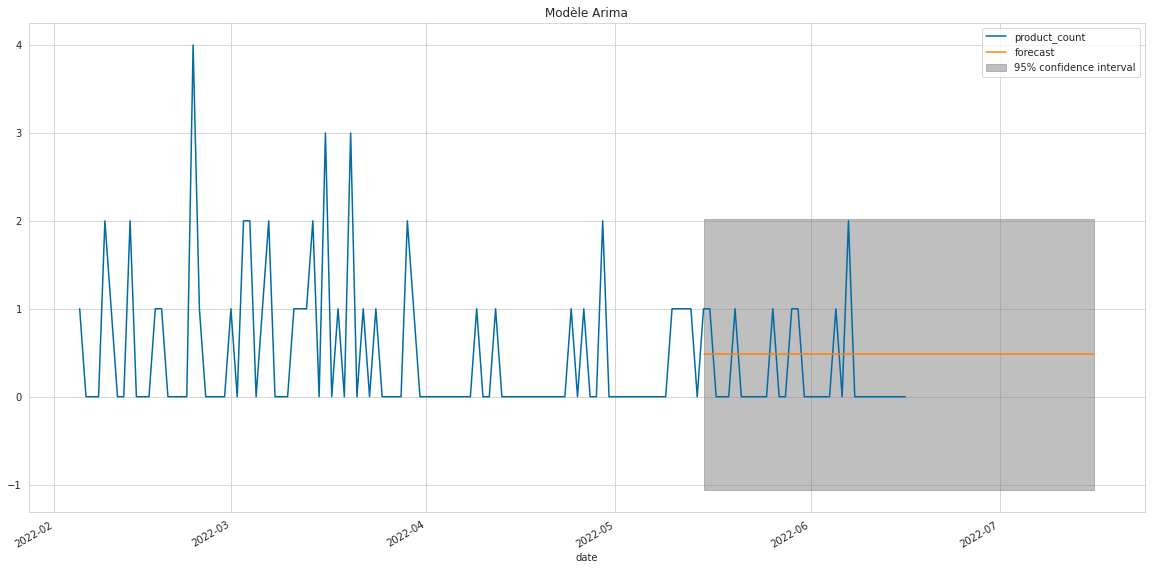

In [42]:
import datetime
fig, ax = plt.subplots()
ax = df_q.loc[datetime.date(2022,2,5):].plot(ax=ax)   
fig =plot_predict(model, start='2022-05-15', end='2022-07-16', dynamic=True, ax=ax,
                        plot_insample=False)
plt.title('Modèle Arima')
plt.savefig('Arima_plot.pdf') 

plt.show()

In [43]:
err_=metrics_(model.forecast(27),df_q.loc[datetime.date(2022,5,21):])
metrics_hist4=pd.DataFrame([err_])

metrics_hist4['Model']='Arima'
metrics_hist4.set_index('Model', inplace = True)

metrics_hist4

MSE       MAE      MSLE
Model                              
Arima  0.314126  0.525374  0.157654

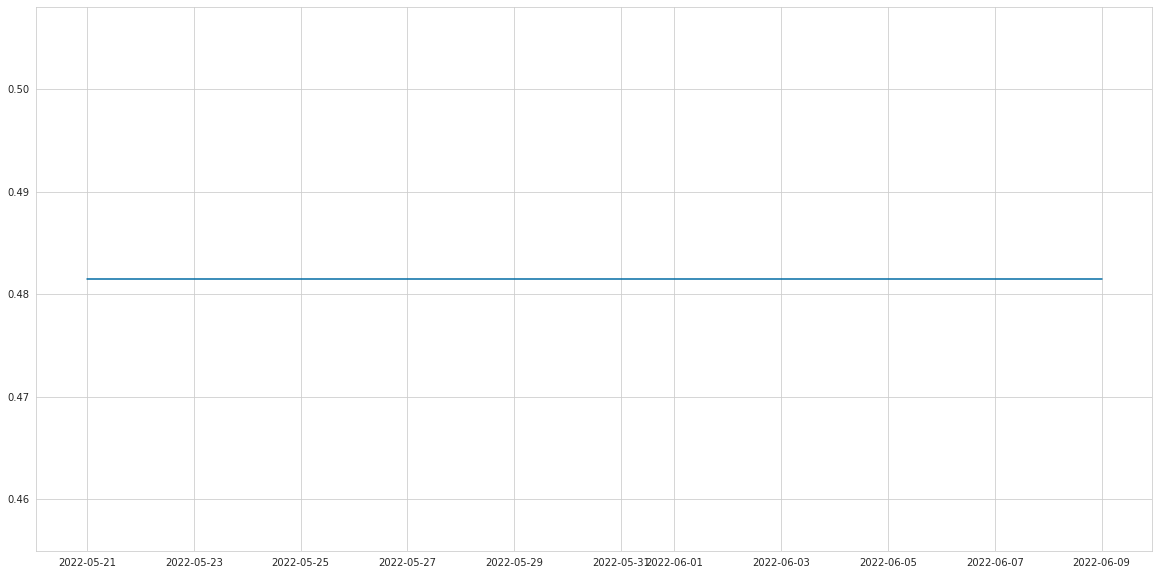

In [44]:
## Prediction sur les 20 prochains jours 
plt.plot(model.forecast(20))

In [45]:
#!pip install pmdarima --quiet

In [46]:
#Standard ARIMA Model
import pmdarima as pm
ARIMA_model = pm.auto_arima(train, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

#### Model Diagnostics
Four plots result from the plot_diagnostics function. 
The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram.
We can interpret the model as a good fit based on the following conditions.
##### Standardized residual
There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.
##### Histogram plus KDE estimate
The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)
##### Normal Q-Q
Most of the data points should lie on the straight line
##### Correlogram (ACF plot)

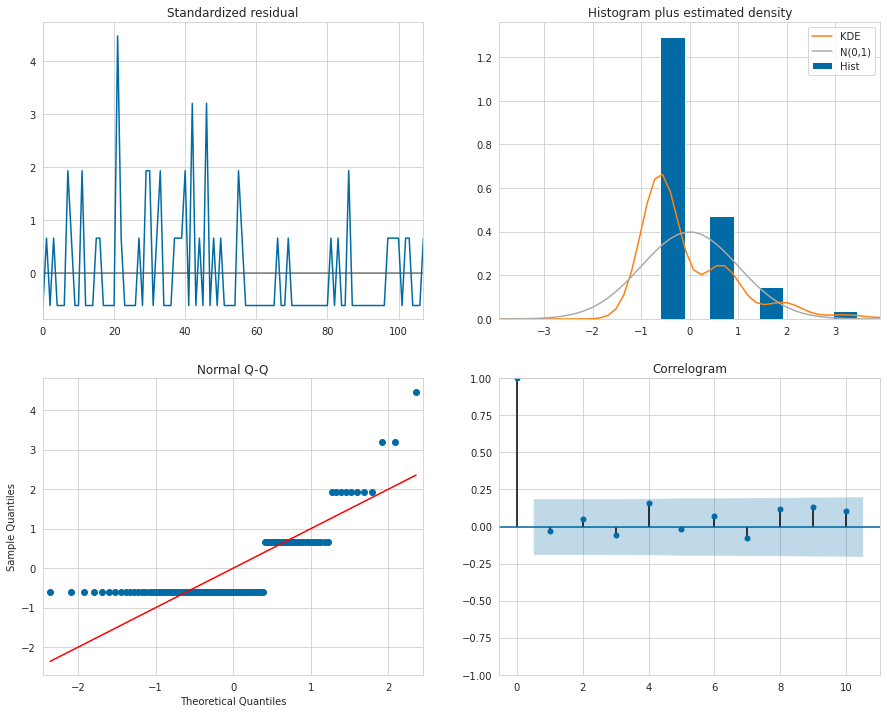

In [47]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

**Commentaire:** Tenter l'approche par différenciation ?

In [48]:
df=df_q.copy()
df["diff"] = np.nan
df.loc[1:, "diff"] = (df.iloc[1:, 0].values - df.iloc[:len(df)-1, 0].values)
pd.concat([df.head(n=3), df.tail(n=3)])

product_count  diff
date                           
2022-02-02            0.0   NaN
2022-02-03            1.0   1.0
2022-02-04            0.0  -1.0
2022-06-14            0.0   0.0
2022-06-15            0.0   0.0
2022-06-16            0.0   0.0

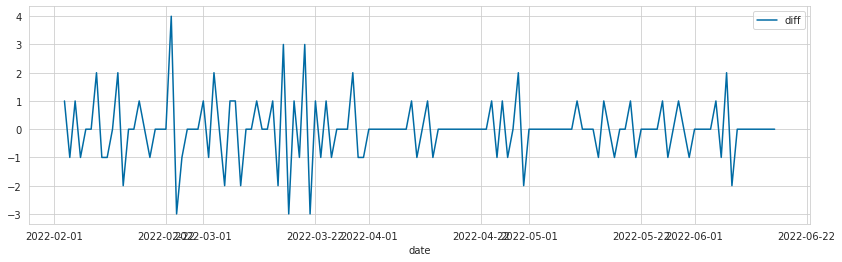

In [49]:
df.plot(y="diff", figsize=(14,4))

**Autocorrelaion:** The next step in our time series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

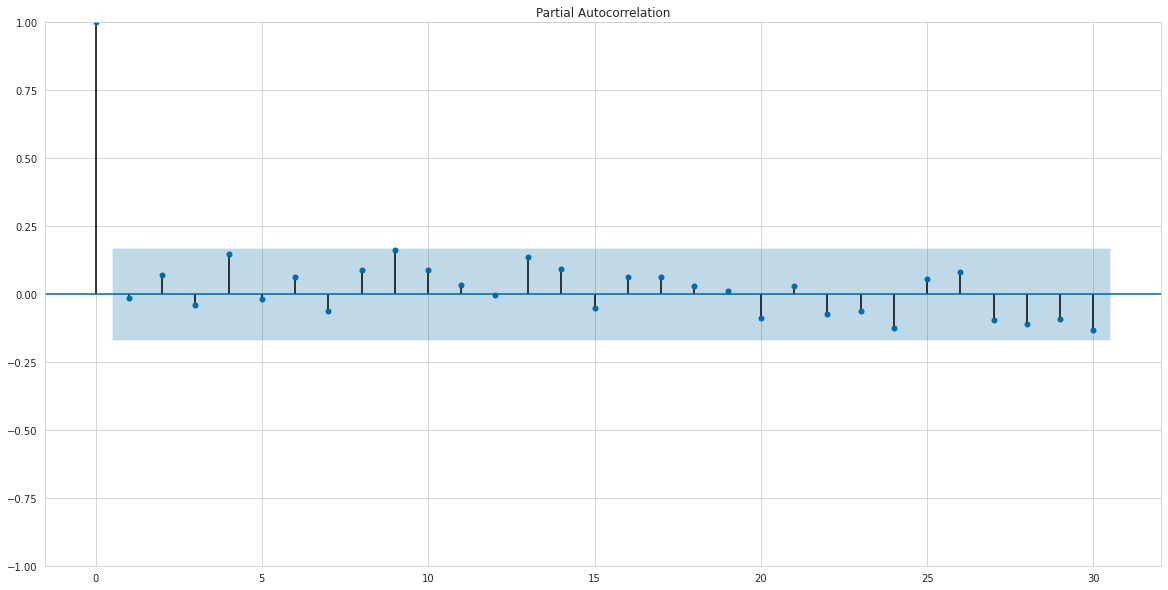

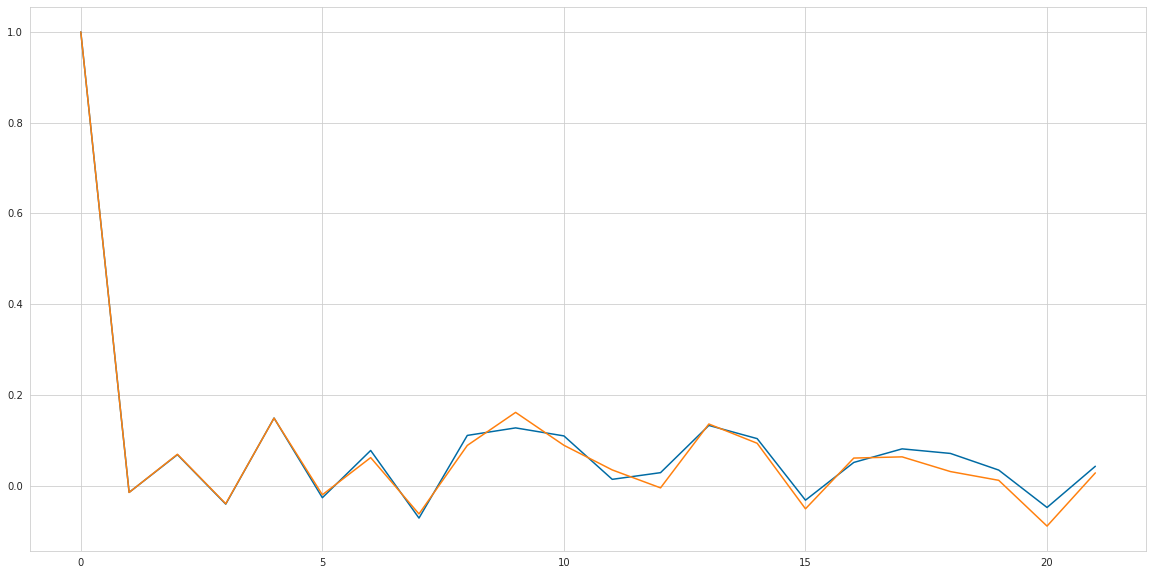

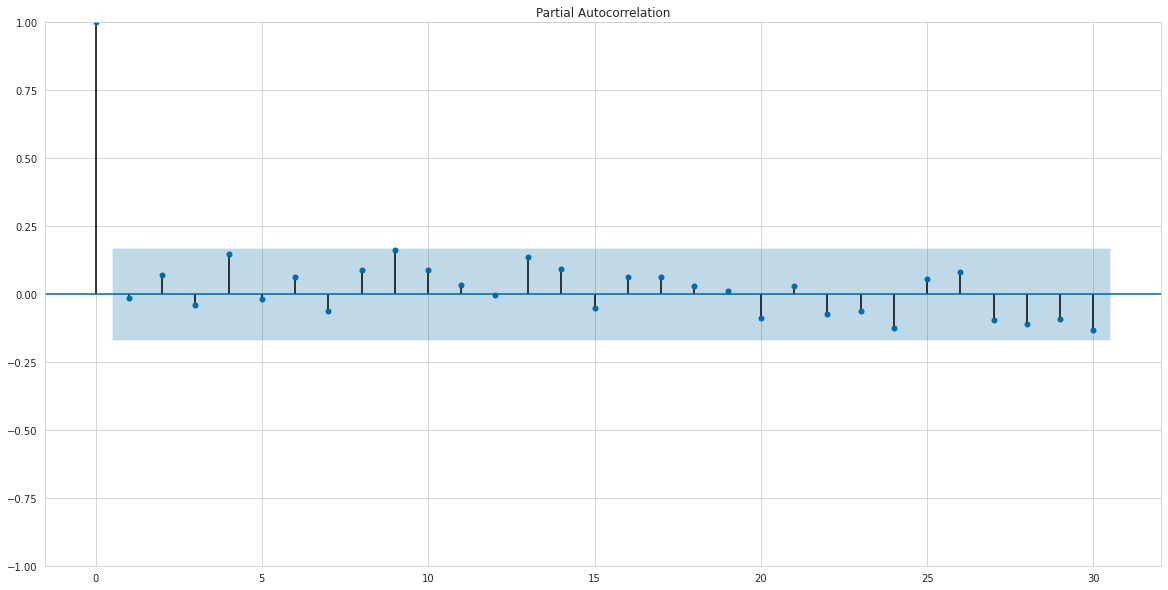

In [50]:
#partial autocorrélation
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


cor = acf(df['product_count'])
plt.plot(cor)


pcor = pacf(df['product_count'])
plt.plot(pcor)
plot_pacf(df_q['product_count'], lags=30)

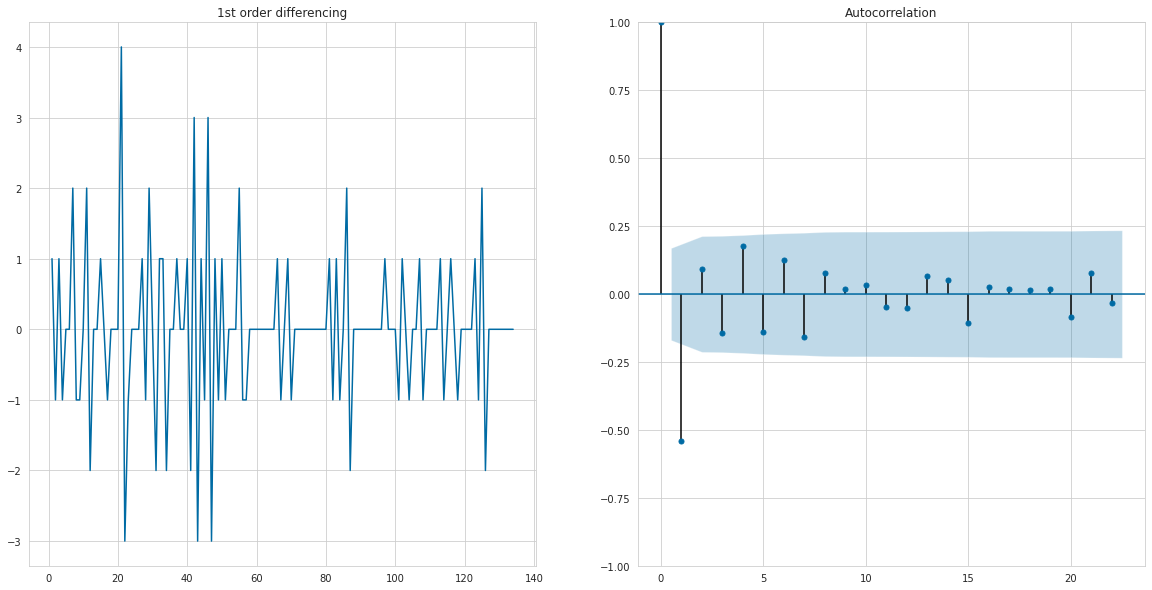

In [51]:
f=plt.figure()
ax1=f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(pd.DataFrame(df['product_count'].values).diff())

ax2=f.add_subplot(122)
plot_acf(pd.DataFrame(df['product_count'].values).diff().dropna(),ax=ax2)
plt.show()

In [52]:
from statsmodels.tsa.arima.model import ARIMA  
arma_mod = ARIMA(df["diff"].dropna().values) #, order=(8, 1))
res = arma_mod.fit()
res.params

array([-4.97240007e-06,  1.13430775e+00])

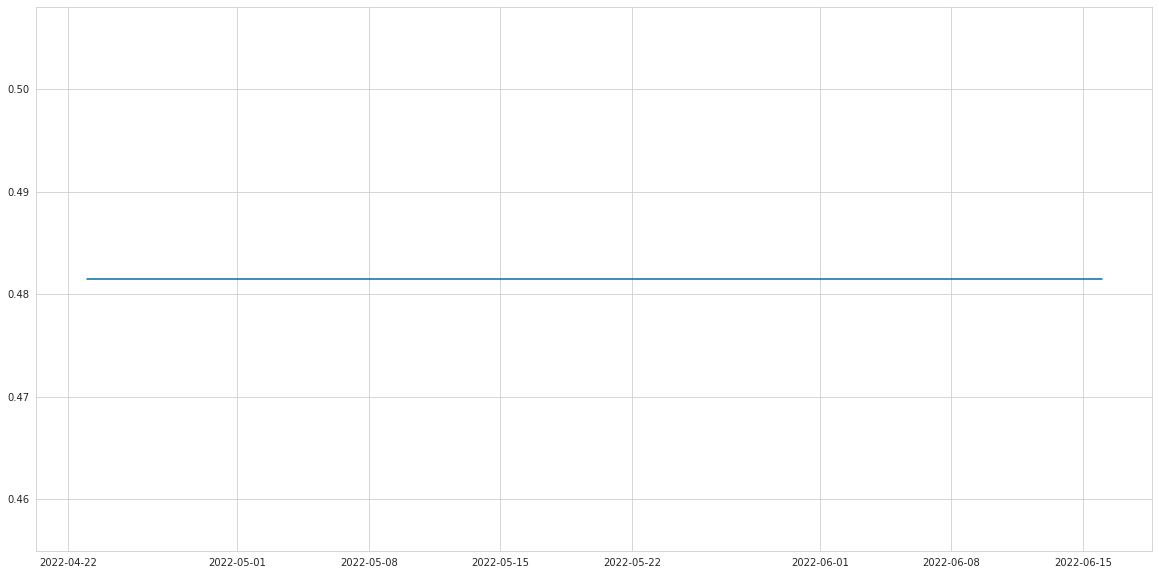

In [53]:
#model.plot_predict(dynamic=False)
#plt.show()
#plt.plot(model.forecast)
y_pred = pd.Series(model.forecast (20)[0], index=df['product_count'][80:]. index)
#y_true = df['product_count'][80:]
plt.plot(y_pred)



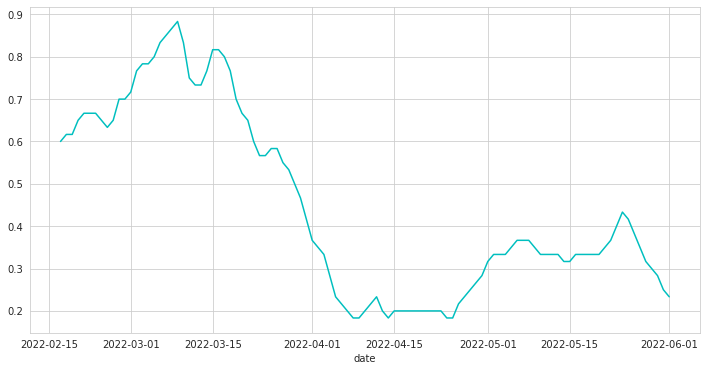

In [54]:
f, ax1 = plt.subplots(1, figsize = (12, 6))

# monthly
decomposition = seasonal_decompose(df_q['product_count'], model = 'additive', period = 30)  #period=30 or freq=30 ?
decomposition.trend.plot(color = 'c', ax = ax1)

#decomposition.seasonal.plot(color = 'r', ax = ax1)
#decomposition.resid.plot(color = 'g', ax = ax1)



The sales seems to decrease over days.

#### Linear regression with mltiple variables ?

In [55]:
# a method to create a variety of features from a time series df
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [56]:
df_q=df_q.reset_index() # set_index('date', inplace=True) if not


In [57]:

df_q['date'] = pd.to_datetime(df_q.date, format='%Y-%m-%d')
X= pd.concat([
    df_q['date'].dt.day,
    df_q['date'].dt.weekday,
    df_q['date'].dt.weekofyear
],axis=1)
X.columns=['day','weekday','weekofyear']

X=pd.get_dummies(X,columns=['weekday']) # one hot encoder in weekdays

X

day  weekofyear  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
0      2           5          0          0          1          0          0   
1      3           5          0          0          0          1          0   
2      4           5          0          0          0          0          1   
3      5           5          0          0          0          0          0   
4      6           5          0          0          0          0          0   
..   ...         ...        ...        ...        ...        ...        ...   
130   12          23          0          0          0          0          0   
131   13          24          1          0          0          0          0   
132   14          24          0          1          0          0          0   
133   15          24          0          0          1          0          0   
134   16          24          0          0          0          1          0   

     weekday_5  weekday_6  
0            0          0  
1            0          0  
2            0          0  
3            1          0  
4            0          1  
..         ...        ...  
130          0          1  
131          0          0  
132          0          0  
133          0          0  
134          0          0  

[135 rows x 9 columns]

In [58]:
#df_q.tail()
rng = pd.date_range(datetime.date(2022,5,1), periods=120, freq='D')
forw = pd.DataFrame({ 'date': rng,'product_count':np.nan}) 

X_for= pd.concat([
    forw['date'].dt.day,
    #forw['date'].dt.month,
    forw['date'].dt.weekday,
    forw['date'].dt.weekofyear
],axis=1)
X_for.columns=['day','weekday','weekofyear']

X_for=pd.get_dummies(X_for,columns=['weekday'])

X_for 

day  weekofyear  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
0      1          17          0          0          0          0          0   
1      2          18          1          0          0          0          0   
2      3          18          0          1          0          0          0   
3      4          18          0          0          1          0          0   
4      5          18          0          0          0          1          0   
..   ...         ...        ...        ...        ...        ...        ...   
115   24          34          0          0          1          0          0   
116   25          34          0          0          0          1          0   
117   26          34          0          0          0          0          1   
118   27          34          0          0          0          0          0   
119   28          34          0          0          0          0          0   

     weekday_5  weekday_6  
0            0          1  
1            0          0  
2            0          0  
3            0          0  
4            0          0  
..         ...        ...  
115          0          0  
116          0          0  
117          0          0  
118          1          0  
119          0          1  

[120 rows x 9 columns]

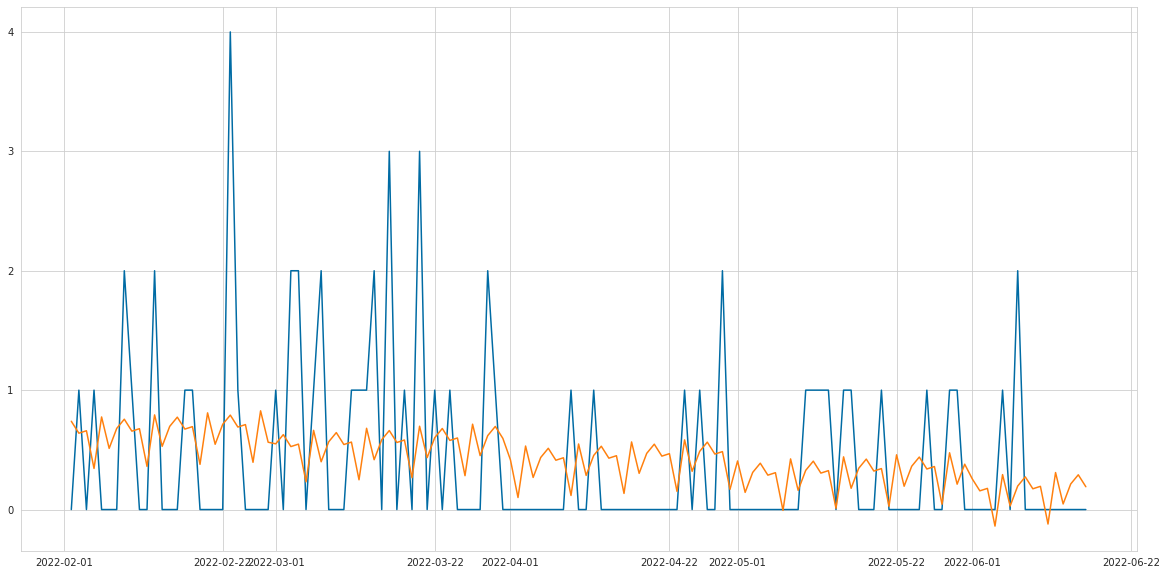

In [59]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X,df_q['product_count'])

# predict on the same period
preds = lr.predict(X)

# plot what has been learned
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(df_q['date'], preds)

In [60]:
coeff=lr.coef_
pd.Series(coeff,index=X.columns)

day           0.006454
weekofyear   -0.028015
weekday_0    -0.102102
weekday_1     0.058850
weekday_2     0.129278
weekday_3     0.022823
weekday_4     0.036950
weekday_5    -0.285294
weekday_6     0.139495
dtype: float64

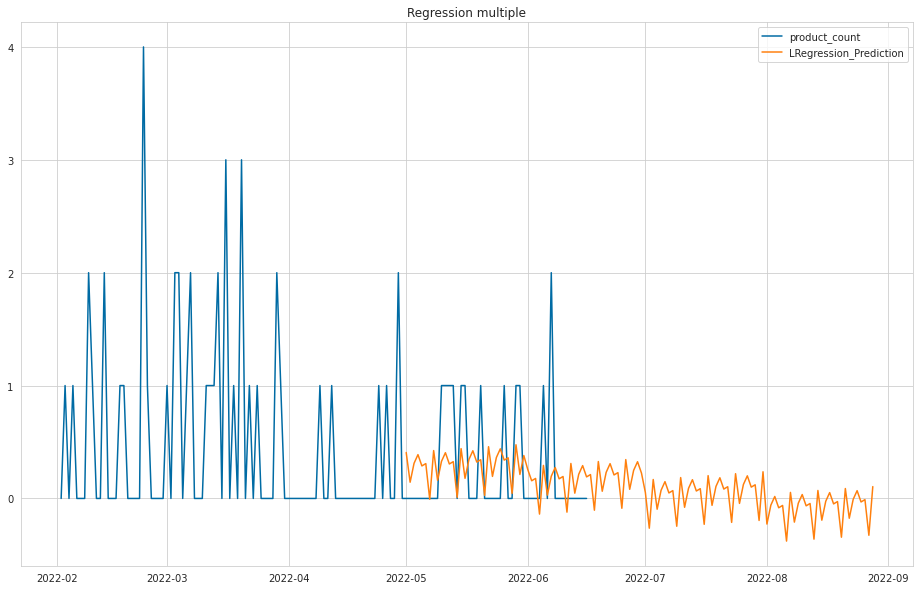

In [61]:
# predict on the future period with Regression
predict = lr.predict(X_for)

# plot what has been learned
#plt.fig(figuresize=(16,10))
fig = plt.figure(1, figsize=(16, 10))
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(forw['date'], predict)
plt.legend(['product_count', 'LRegression_Prediction'])
plt.title('Regression multiple')
plt.savefig('RegressionMultiple_plot.pdf') 

plt.show()

In [62]:
#on test
#datetime.date(2022,5,1)
y_true=df_q.set_index('date').loc[datetime.date(2022,5,1):]

err_l=metrics_(predict[:47],y_true)
metric_l=pd.DataFrame([err_l])
metric_l['Model']='LinearRgression'
metric_l.set_index('Model', inplace = True)
metric_l

MSE       MAE      MSLE
Model                                        
LinearRgression  0.231455  0.373122  0.099485

In [63]:
#on test
#datetime.date(2022,5,1)
df_q=df_q.set_index('date')
y_true=df_q.loc[datetime.date(2022,5,1):]
err_l=metrics_(predict[:47],y_true)
metric_l=pd.DataFrame([err_l])
metric_l['Model']='LinearRgression'
metric_l.set_index('Model', inplace = True)
metric_l

MSE       MAE      MSLE
Model                                        
LinearRgression  0.231455  0.373122  0.099485

**Commentaire**: Regression pas bonne du tout

#### RandomForest

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=80; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=90; total time=   0.1s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=2, n_e

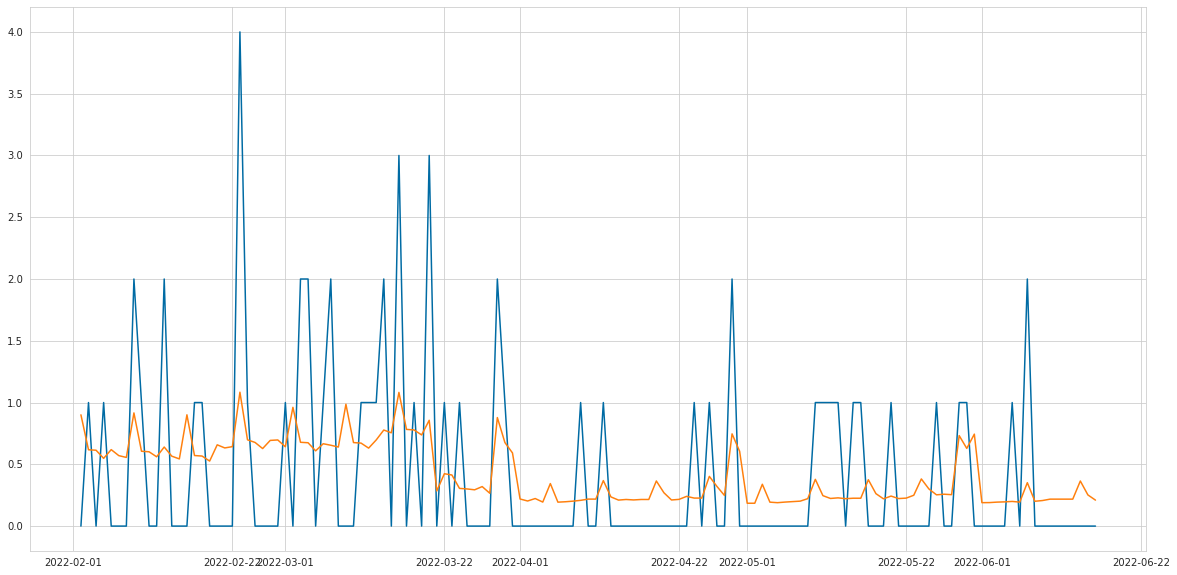

In [64]:
from sklearn.ensemble import RandomForestRegressor

df_q=df_q.reset_index()

# Define Parameters
max_depth=[i for i in range(2,20,2)]
n_estimators = [i for i in range(80,140,10)] #[64, 100, 128]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the grid search
dfrst = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5,verbose=2)
    
# Creating the model on Training Data
grid_results = grid.fit(X, df_q['product_count'])
    
# Extract the best decision forest 
best_clf = grid_results.best_estimator_
   
# Printing all the parameters of Random Forest
print(best_clf)

# predict on the same period
preds = best_clf.predict(X)
 
# plot what has been learned
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(df_q['date'], preds)

In [65]:
#on train
err1_=metrics_(preds,df_q['product_count'])
metrics_hist5=pd.DataFrame([err1_])
metrics_hist5

MSE       MAE      MSLE
0  0.44219  0.517752  0.143744

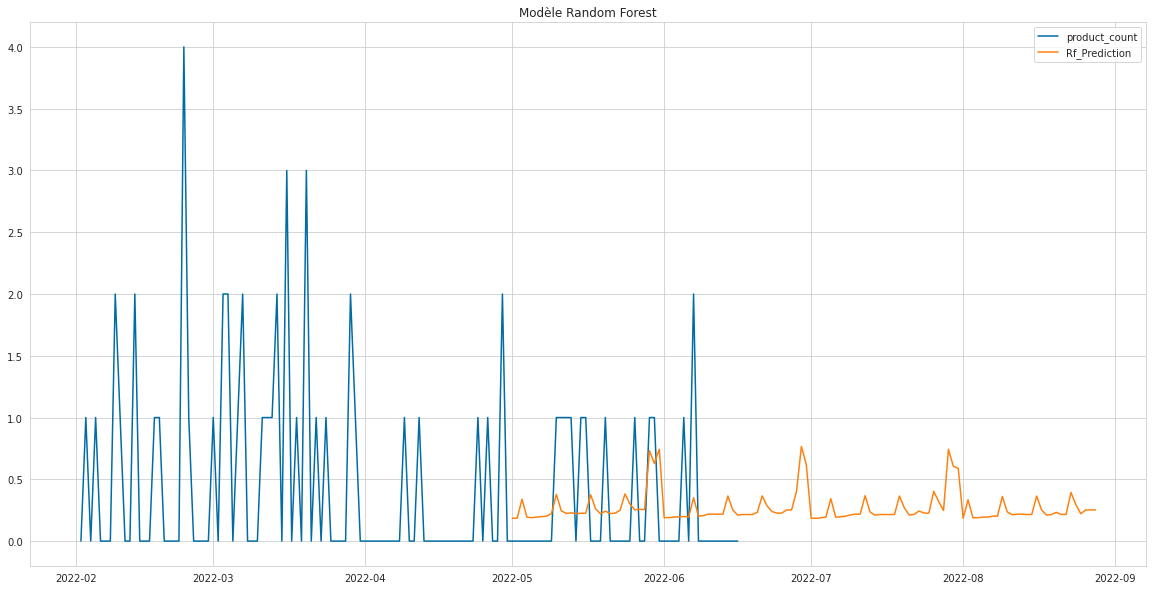

In [66]:
# predict on the future period
predict = best_clf.predict(X_for)
 
# plot what has been learned
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(forw['date'], predict)
plt.legend(['product_count', 'Rf_Prediction'])
plt.title('Modèle Random Forest')
plt.savefig('RandonForest_plot.pdf')

In [67]:
df_q=df_q.set_index('date') #si pas encore(voir ci haut)
y_true=df_q.loc[datetime.date(2022,5,1):]
y_true.shape

(47, 1)

In [68]:
#on test
datetime.date(2022,5,1)
err2_=metrics_(predict[:47],y_true)
metrics_hist6=pd.DataFrame([err2_])
metrics_hist6['Model']='Rand_Forest'
metrics_hist6.set_index('Model', inplace = True)


In [69]:
metrics_hist6

MSE       MAE     MSLE
Model                                   
Rand_Forest  0.224834  0.377911  0.09759

Text(0.5, 0, 'Relative Importance')

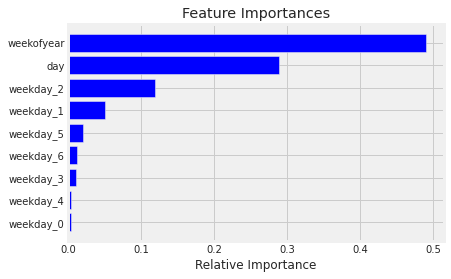

In [70]:
importances = best_clf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
liste_variables = list(pd.DataFrame(X).columns)
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

### Xtreme Gradient Boosting

In [72]:
Predictors=['day','weekday','weekofyear']
# Xtreme Gradient Boosting (XGBoost) with hyperparameter-tuning-with-grid-search 

params = {
    'min_child_weight': [4, 8],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(5, 10)], #range(6,11)?
    'colsample_bytree': [i / 10.0 for i in range(5, 10)],
    'max_depth': [3, 4, 5], ##
    'eta': [0.05, 0.1, 0.15,0.2],
    'n_estimators': [100,1000]
}
    
# Initialize XGB and GridSearch
RegModel=XGBRegressor(max_depth=5, 
                          learning_rate=0.1, 
                          #n_estimators=1000, 
                          alpha = 10,
                          objective='reg:squarederror',
                          booster='gbtree')

grid = GridSearchCV(RegModel, params,cv=5,verbose=2) # the default 5-fold cross validation or None
# Creating the model on Training Data 
grid_results=grid.fit(X, df_q['product_count'],verbose=2)
    
# Extract the best parameters 
best_xgb = grid_results.best_estimator_
    
best_xgb.score(X, df_q['product_count'])
   
# Printing all the parameters of the XGB
print(best_xgb)

Streaming output truncated to the last 5000 lines.
[CV] END colsample_bytree=0.8, eta=0.15, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, eta=0.15, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, eta=0.15, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, eta=0.15, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.8, eta=0.15, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.8, eta=0.15, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.8, eta=0.15, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.6; total tim

In [77]:
 ''' After the running, 
 best_xgb=XGBRegressor(alpha=10, colsample_bytree=0.5, eta=0.05, gamma=0.5,
             min_child_weight=4, objective='reg:squarederror', subsample=0.9)
             '''


" After the running, \nbest_xgb=XGBRegressor(alpha=10, colsample_bytree=0.5, eta=0.05, gamma=0.5,\n            min_child_weight=4, objective='reg:squarederror', subsample=0.9)\n            "

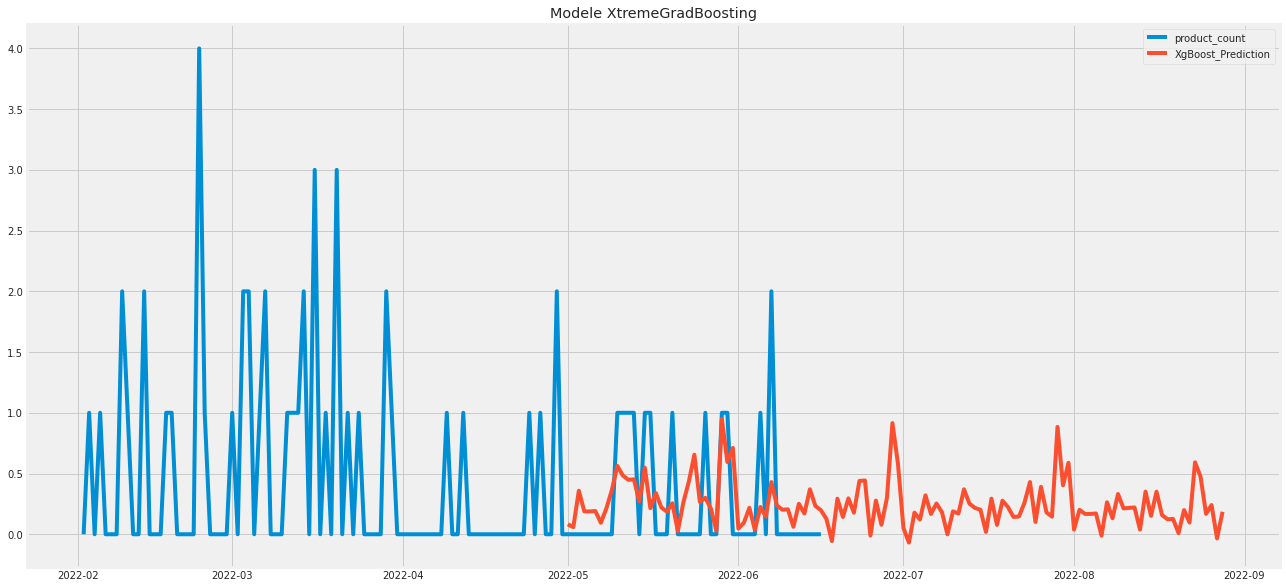

In [78]:
#df_q=df_q.reset_index() ### if not
# predict on the future period
predict =best_xgb.predict(X_for)
 
# plot what has been learned
plt.figure(figsize=(20,10))
plt.plot(df_q['date'], df_q['product_count'])
plt.plot(forw['date'], predict)
plt.legend(['product_count', 'XgBoost_Prediction'])
plt.title('Modele XtremeGradBoosting')
plt.savefig('XtremeGradBoosting_plot.pdf')
plt.show()

##### Metrics on the test

In [79]:
err_XGB=metrics_(predict[:47],y_true)
metrics_hist12=pd.DataFrame([err_XGB])
metrics_hist12['Model']='XtremeGradBoosting'
metrics_hist12.set_index('Model', inplace = True)

In [80]:
metrics_hist12

MSE      MAE      MSLE
Model                                          
XtremeGradBoosting  0.185534  0.32658  0.079107

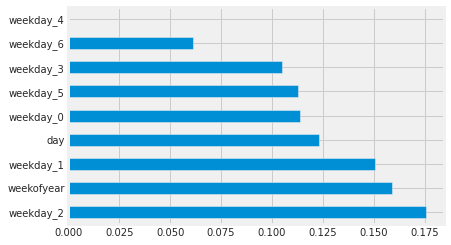

In [81]:
# Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')

###  Artificial Neural Network or ANN models
### Predicting quantity using Deep Learning LSTM model

LSTM is an upgraded or improved version of RNN. Long Short Term Memory (LSTM) connects all time steps via a Memory cell pipeline.

Multi Step LSTM or  time series prediction ,we want to predict quantities for the next 3 days? 

Last 40 days quantites(the window)–> Next 3 days quantities (the horizon)

##### Preparing the data 
we will need data input in the form of X Vs y. Where the X will represent the last 40 day’s quantities and y will represent the next 3 days quantities.
Since LSTM is a Neural network-based algorithm, standardizing or normalizing the data is mandatory for a fast and more accurate fit.

In [82]:
# Extracting the closing quantity of each day
FullData=df_q[['product_count']].values
print(FullData[-10:])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[-10:]

[[2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
### After Normalization ###


array([[0.5],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ],
       [0. ]])

##### Preparing the data for Multi Step LSTM

In [83]:
# Multi step data preparation
 
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next few day's quantity Prediction is based on last how many past day's quantities
FutureTimeSteps=3 # How many days in future you want to predict the quantities
 
# Iterate through the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)

# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0],y_data.shape[1])
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(122, 10, 1)
### Output Data Shape ###
(122, 3)


##### Splitting the data into training and testing: FutureTimeSteps=3.

In [84]:
# Choosing the number of testing data records
TestingRecords=15

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)

print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(107, 10, 1)
(107, 3)

#### Testing Data shape ####
(15, 10, 1)
(15, 3)


##### Visualizing the input and output data for LSTM:  input->output sent to LSTM Multi-step model

In [85]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days quantities we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.  ]
 [0.25]
 [0.  ]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.5 ]
 [0.25]
 [0.  ]]
====>
[0.  0.5 0. ]
####################
[[0.25]
 [0.  ]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.5 ]
 [0.25]
 [0.  ]
 [0.  ]]
====>
[0.5 0.  0. ]
####################


##### Creating the Deep Learning LSTM model

In [86]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [87]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

###################################################################

import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
22/22 [==============================] - 7s 56ms/step - loss: 0.0462
Epoch 2/100
22/22 [==============================] - 1s 55ms/step - loss: 0.0401
Epoch 3/100
22/22 [==============================] - 1s 56ms/step - loss: 0.0376
Epoch 4/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0375
Epoch 5/100
22/22 [==============================] - 1s 55ms/step - loss: 0.0374
Epoch 6/100
22/22 [==============================] - 1s 50ms/step - loss: 0.0372
Epoch 7/100
22/22 [==============================] - 1s 51ms/step - loss: 0.0373
Epoch 8/100
22/22 [==============================] - 1s 54ms/step - loss: 0.0372
Epoch 9/100
22/22 [==============================] - 1s 53ms/step - loss: 0.0371
Epoch 10/100
22/22 [==============================] - 1s 51ms/step - loss: 0.0371
Epoch 11/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0371
Epoch 12/100
22/22 [==============================] - 1s 52ms/step - loss: 0.0372
Epoch 13/100
22/22 [=====

##### Measuring the accuracy of the model on testing data

In [89]:
# Making predictions on test data
predicted_Quantities = regressor.predict(X_test)
predicted_Quantities = DataScaler.inverse_transform(predicted_Quantities)
print('#### Predicted Quantities ####')
print(predicted_Quantities)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Quantities ####')
print(orig)

#### Predicted Quantities ####
[[0.32177132 0.33612043 0.29037988]
 [0.3124218  0.32232004 0.2759304 ]
 [0.31881857 0.3385529  0.28593254]
 [0.32593098 0.3547391  0.2970968 ]
 [0.33324802 0.36946714 0.30857295]
 [0.3402223  0.38159767 0.31945896]
 [0.34632552 0.39033931 0.32890645]
 [0.330882   0.35709065 0.30478135]
 [0.33549395 0.3650017  0.31183925]
 [0.34487647 0.38117486 0.32436213]
 [0.33005533 0.3596419  0.3025692 ]
 [0.32489538 0.35436344 0.29457858]
 [0.34018862 0.3773775  0.31506714]
 [0.35772198 0.3985157  0.3377478 ]
 [0.37553632 0.41734907 0.36060512]]

#### Original Quantities ####
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 2.]
 [0. 2. 0.]
 [2. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [90]:
err=metrics_(orig,predicted_Quantities)

#err2_=metrics_(predict[:47],y_true)
metrics_hist7=pd.DataFrame([err])
metrics_hist7['Model']='LSTM-ANN'
metrics_hist7.set_index('Model', inplace = True)
metrics_hist7

MSE      MAE      MSLE
Model                                
LSTM-ANN  0.319436  0.45423  0.129314

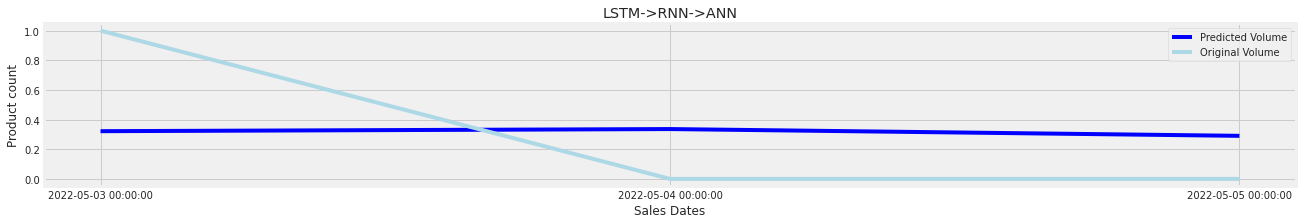

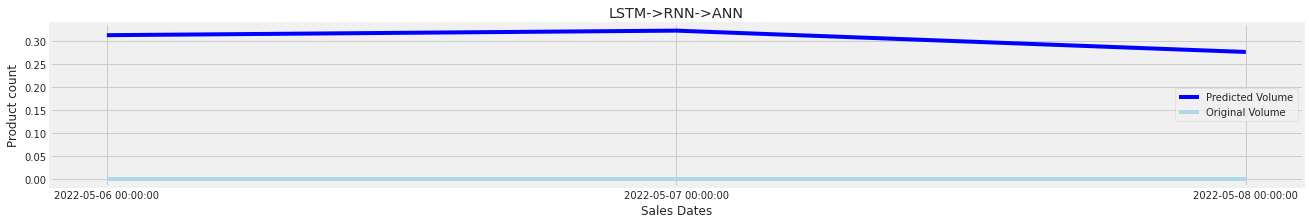

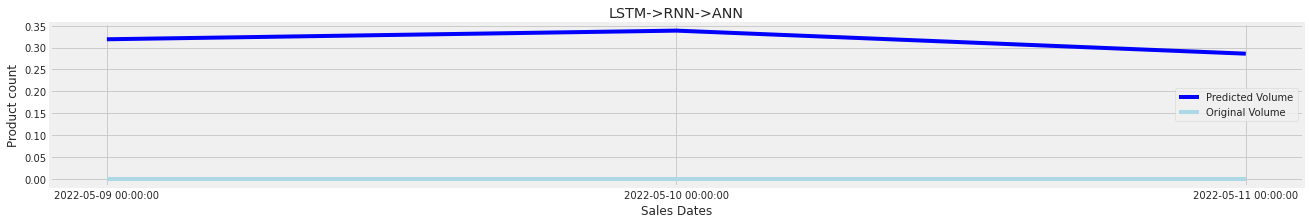

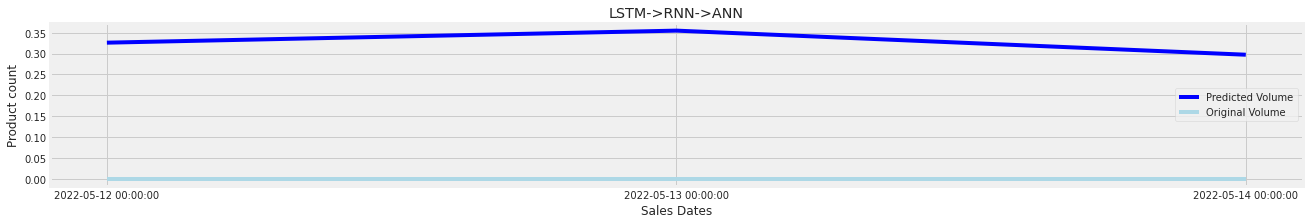

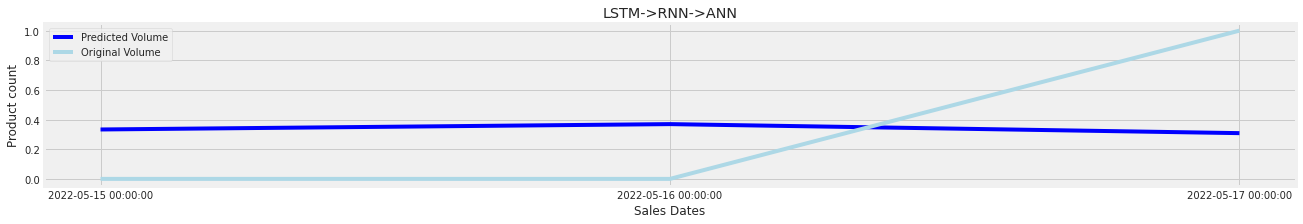

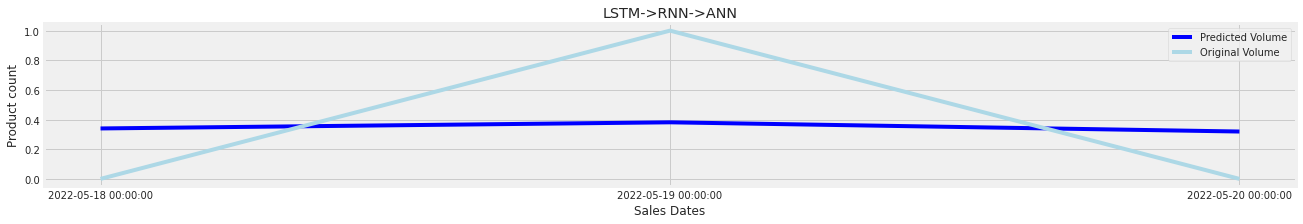

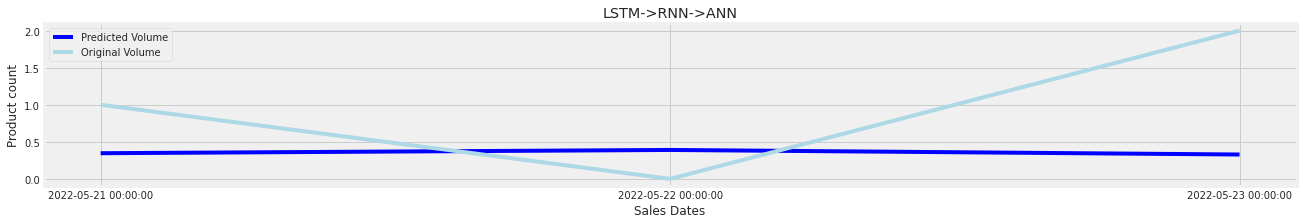

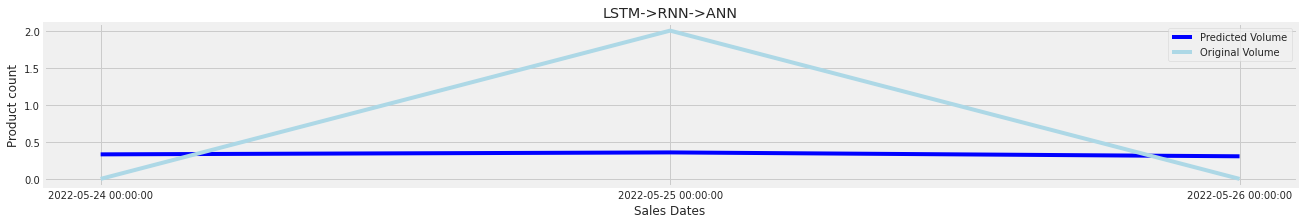

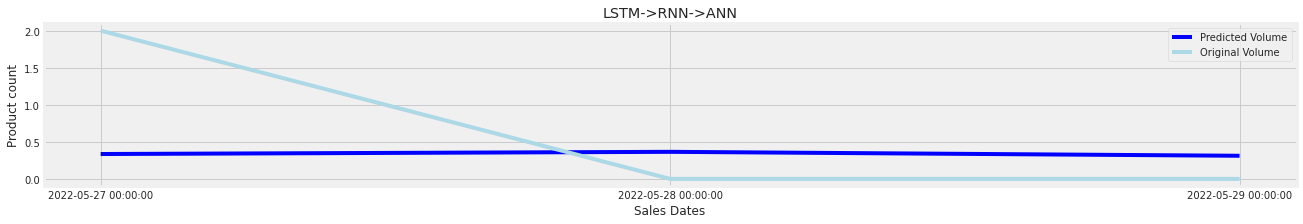

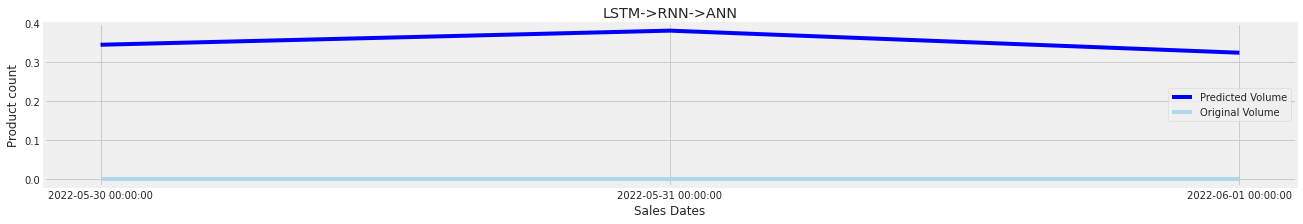

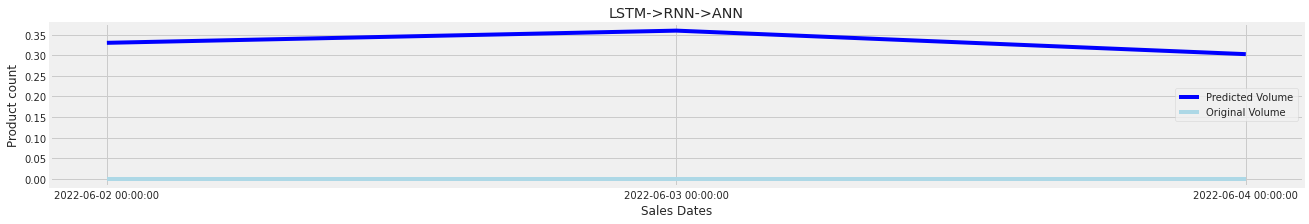

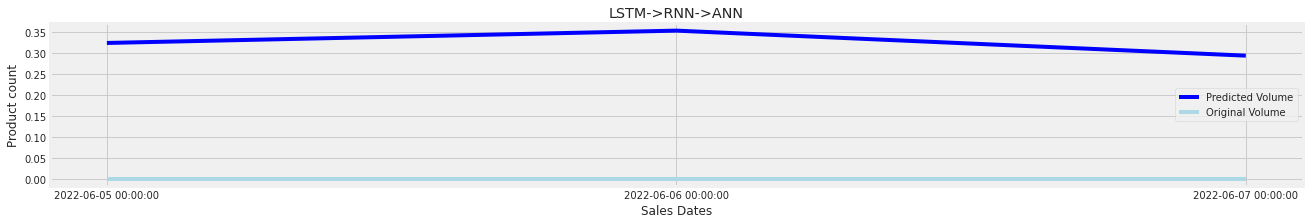

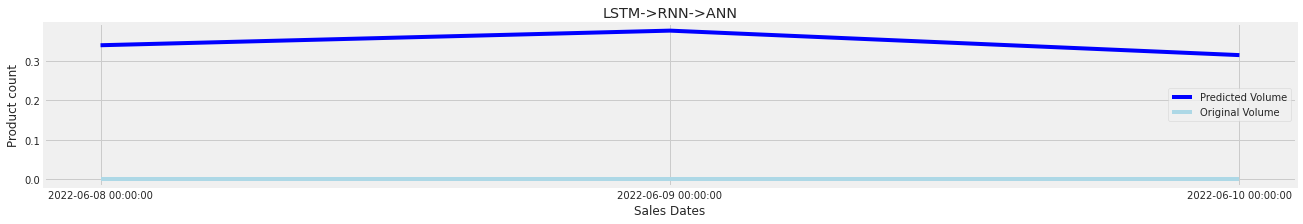

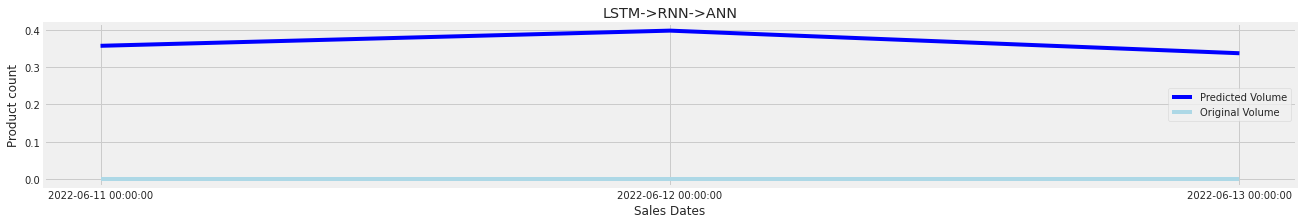

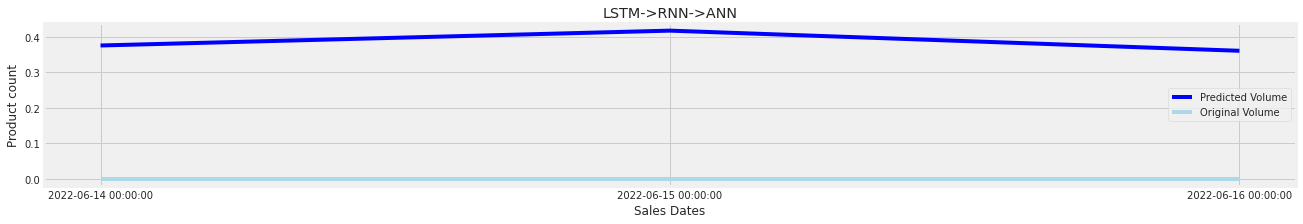

In [91]:
import matplotlib.pyplot as plt

for i in range(len(orig)):
    Prediction=predicted_Quantities[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')

    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Sales Dates')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=df_q.shape[0]

    plt.xticks(range(FutureTimeSteps), df_q.reset_index().iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['date'])
    plt.ylabel('Product count')

    plt.legend()
    plt.title('LSTM->RNN->ANN')
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    if(i==0):
      plt.savefig('LSTM_plot.pdf')
    plt.show()

##### Visualizing the predictions for full data

##### Making predictions for the next 3 days

In [92]:
# Making predictions on test data
Last10DaysQuantities=np.array([2, 1,0,0 ,4, 
                   2, 1, 0, 5 ,3])

# Reshaping the data to (-1,1 )because its a single entry
Last10DaysQuantities=Last10DaysQuantities.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysQuantities)

NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)

# Generating the predictions for next 5 days
Next5DaysQuantities = regressor.predict(X_test)

# Generating the prices in original scale
Next5DaysQuantities = DataScaler.inverse_transform(Next5DaysQuantities)
Next5DaysQuantities

array([[0.36124235, 0.3718762 , 0.32926354]], dtype=float32)

### Autre algorithmes

##### Multi-Step MLP Models for  univariate Time Series Forecasting

In [93]:
# multi-step data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [94]:
data_train=df_q.iloc[:-47,:]
data_test=df_q.iloc[-47:,:]

In [95]:

# define input sequence
raw_seq = data_train['product_count']
# choose a number of time steps
n_steps_in, n_steps_out = 10, 3
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[0. 1. 0. 1. 0. 0. 0. 2. 1. 0.] [0. 2. 0.]
[1. 0. 1. 0. 0. 0. 2. 1. 0. 0.] [2. 0. 0.]
[0. 1. 0. 0. 0. 2. 1. 0. 0. 2.] [0. 0. 0.]
[1. 0. 0. 0. 2. 1. 0. 0. 2. 0.] [0. 0. 1.]
[0. 0. 0. 2. 1. 0. 0. 2. 0. 0.] [0. 1. 1.]
[0. 0. 2. 1. 0. 0. 2. 0. 0. 0.] [1. 1. 0.]
[0. 2. 1. 0. 0. 2. 0. 0. 0. 1.] [1. 0. 0.]
[2. 1. 0. 0. 2. 0. 0. 0. 1. 1.] [0. 0. 0.]
[1. 0. 0. 2. 0. 0. 0. 1. 1. 0.] [0. 0. 0.]
[0. 0. 2. 0. 0. 0. 1. 1. 0. 0.] [0. 0. 4.]
[0. 2. 0. 0. 0. 1. 1. 0. 0. 0.] [0. 4. 1.]
[2. 0. 0. 0. 1. 1. 0. 0. 0. 0.] [4. 1. 0.]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 4.] [1. 0. 0.]
[0. 0. 1. 1. 0. 0. 0. 0. 4. 1.] [0. 0. 0.]
[0. 1. 1. 0. 0. 0. 0. 4. 1. 0.] [0. 0. 0.]
[1. 1. 0. 0. 0. 0. 4. 1. 0. 0.] [0. 0. 1.]
[1. 0. 0. 0. 0. 4. 1. 0. 0. 0.] [0. 1. 0.]
[0. 0. 0. 0. 4. 1. 0. 0. 0. 0.] [1. 0. 2.]
[0. 0. 0. 4. 1. 0. 0. 0. 0. 1.] [0. 2. 2.]
[0. 0. 4. 1. 0. 0. 0. 0. 1. 0.] [2. 2. 0.]
[0. 4. 1. 0. 0. 0. 0. 1. 0. 2.] [2. 0. 1.]
[4. 1. 0. 0. 0. 0. 1. 0. 2. 2.] [0. 1. 2.]
[1. 0. 0. 0. 0. 1. 0. 2. 2. 0.] [1. 2. 0.]
[0. 0. 0. 0

In [96]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=2000, verbose=2)


Epoch 1/2000
3/3 - 0s - loss: 1.3392 - 314ms/epoch - 105ms/step
Epoch 2/2000
3/3 - 0s - loss: 1.1846 - 10ms/epoch - 3ms/step
Epoch 3/2000
3/3 - 0s - loss: 1.0724 - 10ms/epoch - 3ms/step
Epoch 4/2000
3/3 - 0s - loss: 0.9770 - 10ms/epoch - 3ms/step
Epoch 5/2000
3/3 - 0s - loss: 0.9058 - 10ms/epoch - 3ms/step
Epoch 6/2000
3/3 - 0s - loss: 0.8508 - 10ms/epoch - 3ms/step
Epoch 7/2000
3/3 - 0s - loss: 0.8102 - 10ms/epoch - 3ms/step
Epoch 8/2000
3/3 - 0s - loss: 0.7823 - 10ms/epoch - 3ms/step
Epoch 9/2000
3/3 - 0s - loss: 0.7598 - 13ms/epoch - 4ms/step
Epoch 10/2000
3/3 - 0s - loss: 0.7454 - 11ms/epoch - 4ms/step
Epoch 11/2000
3/3 - 0s - loss: 0.7322 - 10ms/epoch - 3ms/step
Epoch 12/2000
3/3 - 0s - loss: 0.7210 - 12ms/epoch - 4ms/step
Epoch 13/2000
3/3 - 0s - loss: 0.7113 - 10ms/epoch - 3ms/step
Epoch 14/2000
3/3 - 0s - loss: 0.7027 - 10ms/epoch - 3ms/step
Epoch 15/2000
3/3 - 0s - loss: 0.6928 - 11ms/epoch - 4ms/step
Epoch 16/2000
3/3 - 0s - loss: 0.6832 - 10ms/epoch - 3ms/step
Epoch 17/2000


In [104]:
data_test=data_test.set_index('date')

In [105]:
# demonstrate prediction
x_test,y_test = split_sequence(data_test, n_steps_in, n_steps_out)
#x_test = x_test.reshape((1, n_steps_in))
y_test=y_test.reshape(y_test.shape[0],y_test.shape[1])

yhat = model.predict(x_test, verbose=2)
print(yhat)

2/2 - 0s - 63ms/epoch - 32ms/step
[[-0.00773942  0.45818958  0.5452889 ]
 [-0.12010665  0.03043612  0.13010225]
 [-0.16183393  0.8570986   1.3009666 ]
 [ 0.07930119  1.6150206   0.27014866]
 [ 0.95029205  1.771112   -0.06967613]
 [ 0.1574955   0.29748642 -0.04464075]
 [-0.3896955  -0.13786481  0.31413525]
 [-0.03465326  1.0067147   0.93431234]
 [ 0.29555494  0.35414073  1.3817958 ]
 [ 0.5554382   0.6617972   0.75184   ]
 [ 1.053399    0.83057845  0.23454323]
 [ 0.86633235  0.20956413 -0.12010601]
 [ 0.8792112  -0.42916745  1.2518696 ]
 [-0.7143697   1.0065494   1.0183252 ]
 [ 0.9013452   1.2281183   0.25973192]
 [ 0.7723013   0.01455557 -0.56402063]
 [ 0.2566566   0.5049708   0.67307496]
 [ 0.6512346   0.5372548  -0.2790518 ]
 [ 0.2589049  -0.5528225   0.22269449]
 [-0.30813727  0.25049764  0.32922307]
 [-0.12472691  0.02881647  0.00626823]
 [-0.24218442  0.7634091  -0.22847387]
 [ 0.6137376   0.29815134 -0.02994081]
 [ 0.31070146  1.0683343   0.36754492]
 [-0.16901335  1.0487686   0.2

In [106]:
print(y_test.shape)
print(yhat.shape)

(35, 3)
(35, 3)


In [107]:
err7=metrics_(y_test,yhat)
metrics_hist8=pd.DataFrame([err7])
metrics_hist8['Model']='MLP-ANN'
metrics_hist8.set_index('Model', inplace = True)
metrics_hist8

MSE      MAE      MSLE
Model                               
MLP-ANN  0.522334  0.56494  0.193966

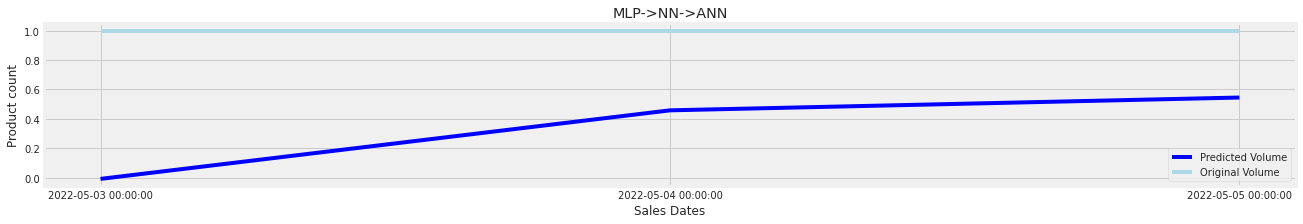

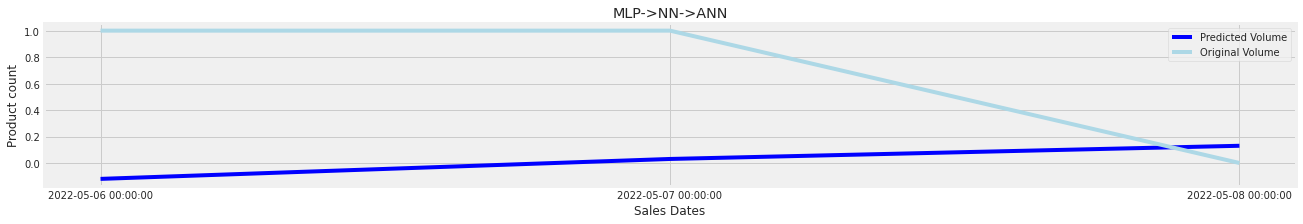

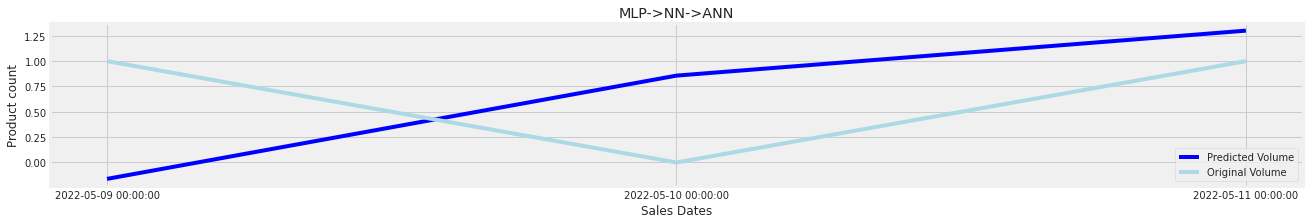

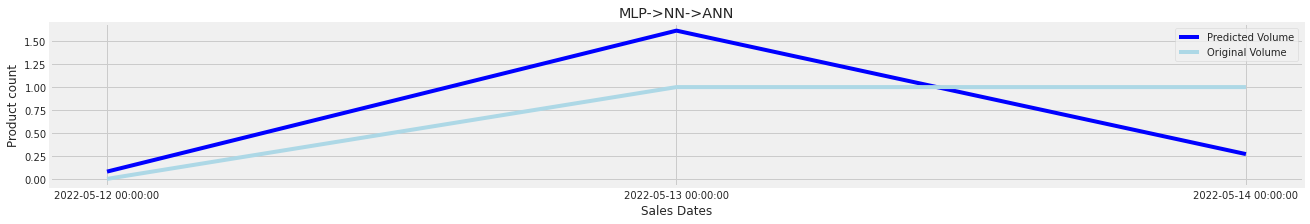

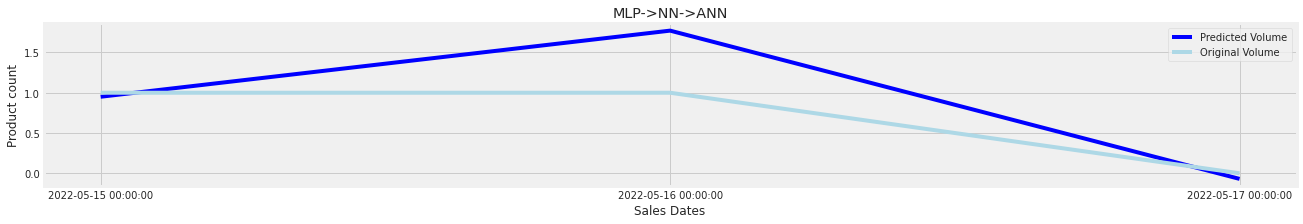

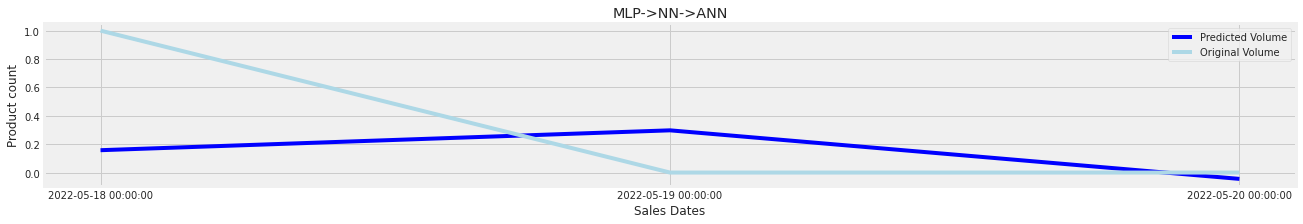

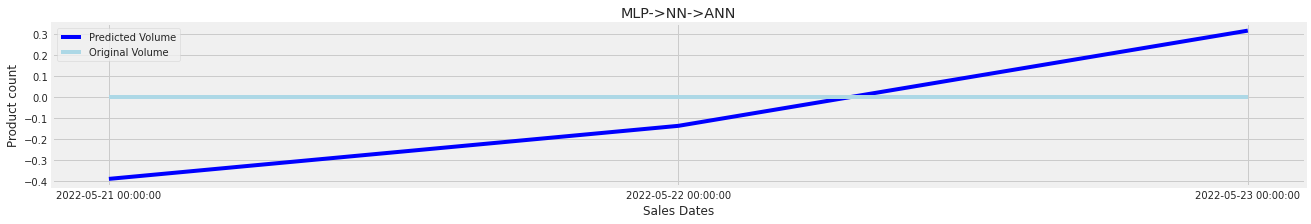

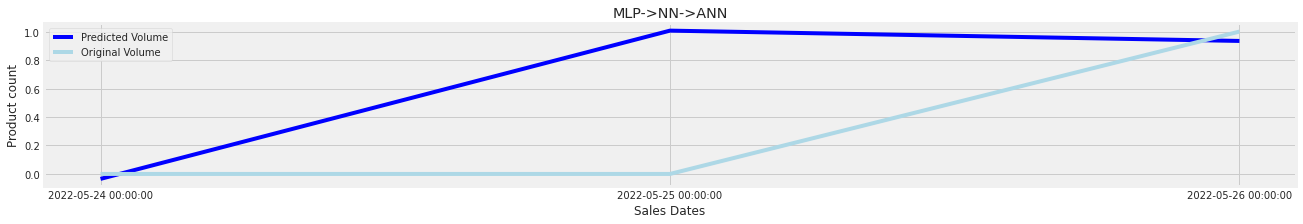

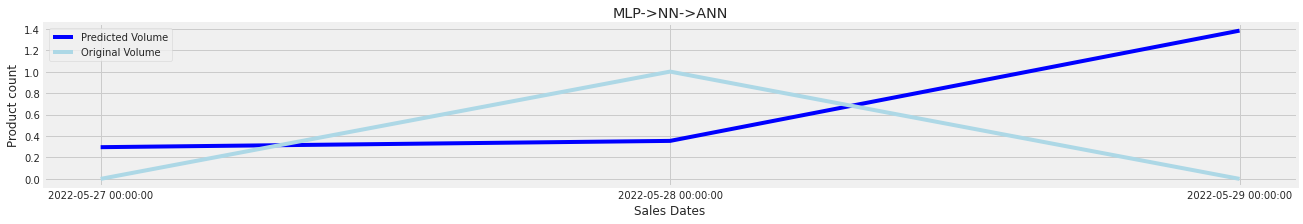

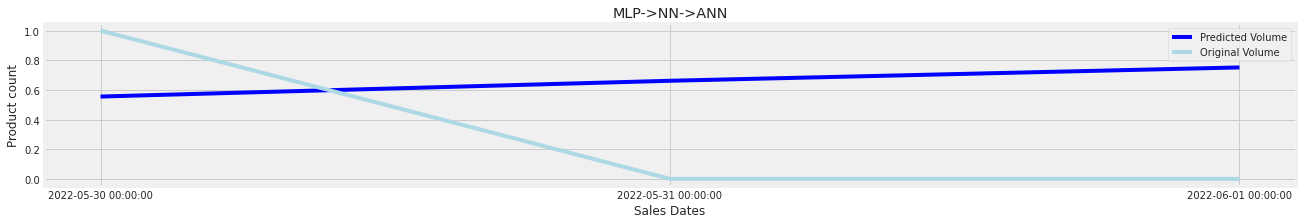

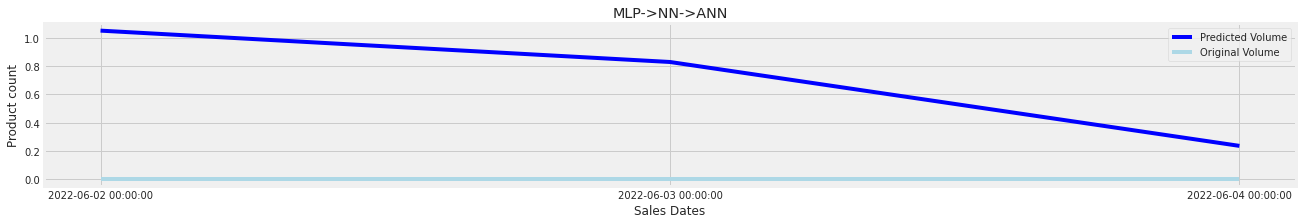

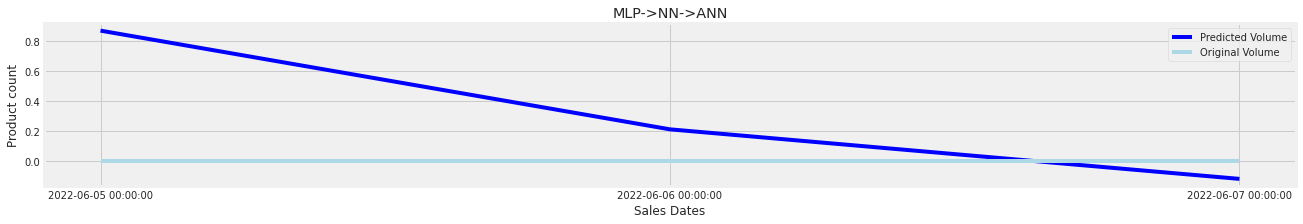

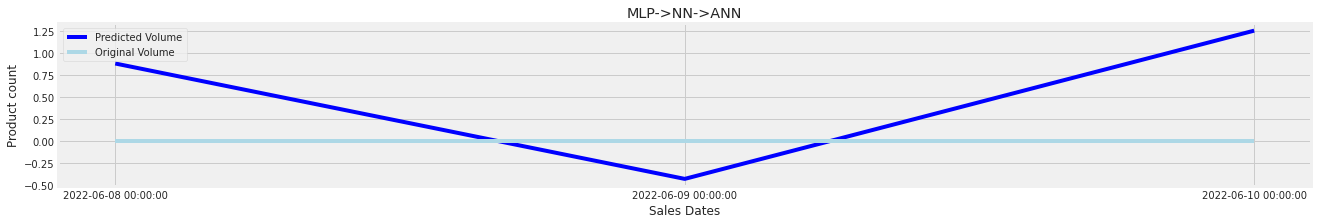

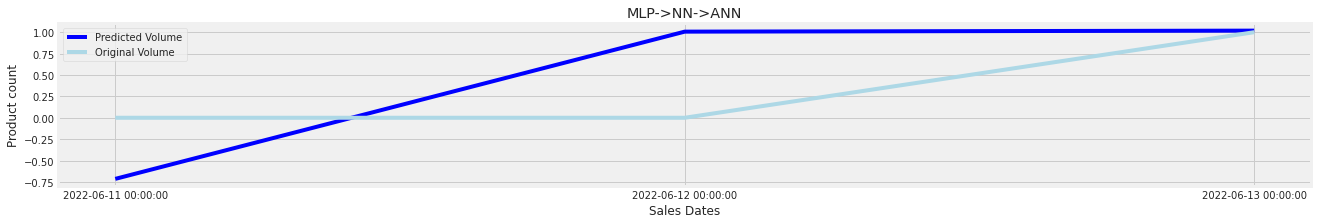

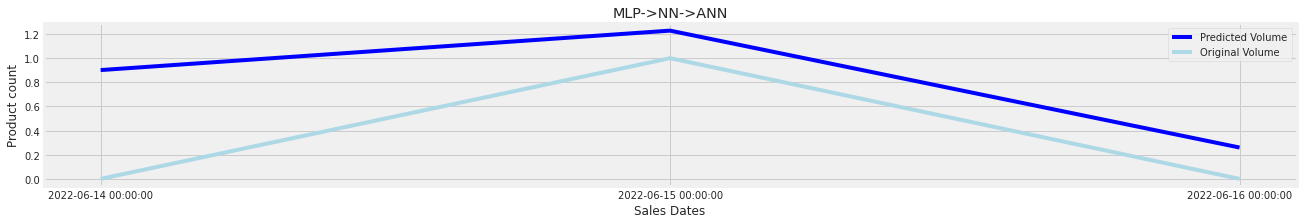

In [108]:
import matplotlib.pyplot as plt

for i in range(len(orig)):
    Prediction=yhat [i]
    Original=y_test[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')

    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Sales Dates')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=df_q.shape[0]

    plt.xticks(range(FutureTimeSteps), df_q.reset_index().iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['date'])
    plt.ylabel('Product count')

    plt.legend()
    plt.title('MLP->NN->ANN')
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    if(i==4):
      plt.savefig('MLP_plot.pdf')
    plt.show()

### Summary ?

In [109]:
frames=(metrics_hist,metrics_hist3,metrics_hist4,metric_l,metrics_hist6,metrics_hist8,metrics_hist7)
m= pd.concat(frames).reset_index()

In [110]:
m

Model       MSE       MAE      MSLE
0  Xgboost_roll (day by day)  0.337735  0.535137  0.161505
1              Rolling or MA  0.582741  0.568148  0.194343
2                      Arima  0.314126  0.525374  0.157654
3            LinearRgression  0.231455  0.373122  0.099485
4                Rand_Forest  0.224834  0.377911  0.097590
5                    MLP-ANN  0.522334  0.564940  0.193966
6                   LSTM-ANN  0.319436  0.454230  0.129314

In [111]:
m.to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n{} &                      Model &       MSE &       MAE &      MSLE \\\\\n\\midrule\n0 &  Xgboost\\_roll (day by day) &  0.337735 &  0.535137 &  0.161505 \\\\\n1 &              Rolling or MA &  0.582741 &  0.568148 &  0.194343 \\\\\n2 &                      Arima &  0.314126 &  0.525374 &  0.157654 \\\\\n3 &            LinearRgression &  0.231455 &  0.373122 &  0.099485 \\\\\n4 &                Rand\\_Forest &  0.224834 &  0.377911 &  0.097590 \\\\\n5 &                    MLP-ANN &  0.522334 &  0.564940 &  0.193966 \\\\\n6 &                   LSTM-ANN &  0.319436 &  0.454230 &  0.129314 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### ExponentialSmoothing (Lissage Exponentiel)

In [112]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

#### Simple Exponential Smoothing.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


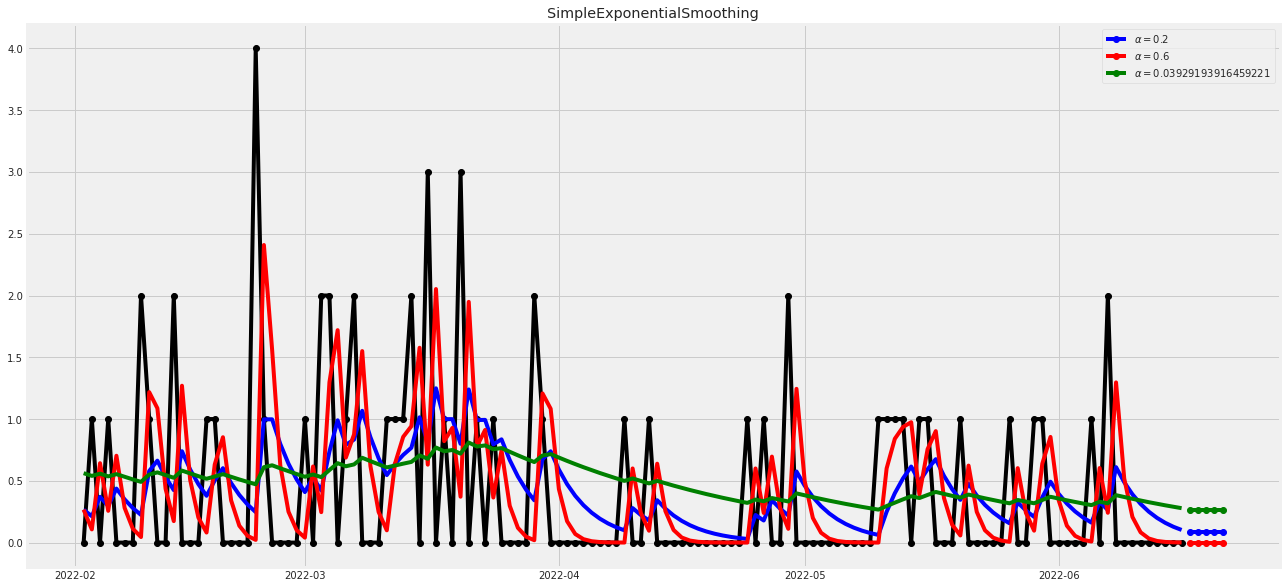

In [113]:
fit1 = SimpleExpSmoothing(values, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False)

fcast1 = fit1.forecast(5).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(values, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False)

fcast2 = fit2.forecast(5).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(values, initialization_method="estimated").fit()
fcast3 = fit3.forecast(5).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(20, 10))
plt.plot(values, marker="o",color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o",color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2,marker="o", color="red")
plt.plot(fit3.fittedvalues, color="green")
(line3,) = plt.plot(fcast3, marker="o",color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])
plt.title('SimpleExponentialSmoothing')
plt.savefig('SimpleExpSmoothing_plot.pdf')

In [196]:
df_q=df_q.set_index('date')
y_true=df_q.loc[datetime.date(2022,5,1):] #set_index('date') if not
df_q.tail()

product_count
date                     
2022-06-12            0.0
2022-06-13            0.0
2022-06-14            0.0
2022-06-15            0.0
2022-06-16            0.0

In [116]:
start_date=datetime.date(2022,5,1)
end_date=datetime.date(2022,6,16)
yhat1=fit3.predict(start=start_date, end=end_date)

In [117]:
err_S_Ex=metrics_(y_true,yhat1)
metrics_hist9=pd.DataFrame([err_S_Ex])
metrics_hist9['Model']='SimpleExpSmoothing'
metrics_hist9.set_index('Model', inplace = True)
metrics_hist9

MSE       MAE      MSLE
Model                                           
SimpleExpSmoothing  0.253642  0.447524  0.118435

#### Holt’s Method or double exponential smoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


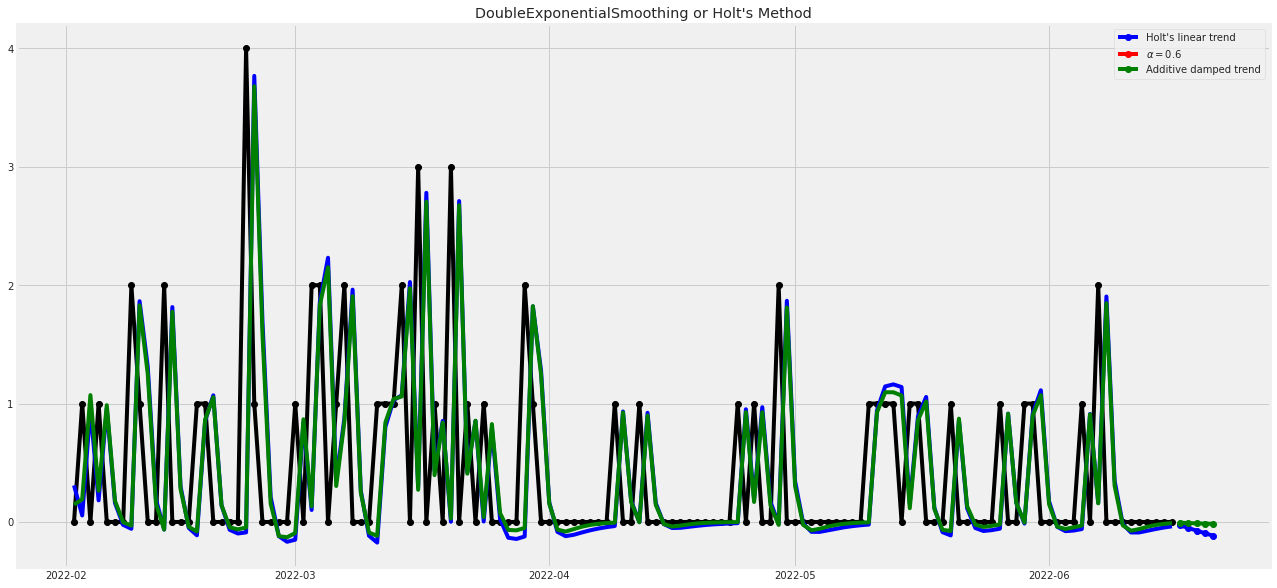

In [118]:
fit1 = Holt(values, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False)

fcast1 = fit1.forecast(5).rename("Holt's linear trend")
#fit2 = Holt(values, exponential=True, initialization_method="estimated").fit(
#    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
#)
#fcast2 = fit2.forecast(5).rename("Exponential trend")

fit3 = Holt(values, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2)

fcast3 = fit3.forecast(5).rename("Additive damped trend")

plt.figure(figsize=(20, 10))
plt.plot(values, marker="o", color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
#plt.plot(fit2.fittedvalues, color="red")
#(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])
plt.title("DoubleExponentialSmoothing or Holt's Method")
plt.savefig('DoubleExpSmoothing_plot.pdf')

In [119]:
yhat2=fit3.predict(start=start_date, end=end_date)

In [197]:
err_D_Ex=metrics_(y_true,yhat2)
metrics_hist10=pd.DataFrame([err_D_Ex])
metrics_hist10['Model']='DoubleExpSmoothing'
metrics_hist10.set_index('Model', inplace = True)
metrics_hist10

MSE       MAE      MSLE
Model                                           
DoubleExpSmoothing  0.403778  0.384031  0.161938

### Summary

In [121]:
frames=(metrics_hist,metrics_hist3,metrics_hist4,metric_l,metrics_hist6,metrics_hist9,metrics_hist10,metrics_hist8,metrics_hist7)
m_= pd.concat(frames).reset_index()
m_

Model       MSE       MAE      MSLE
0  Xgboost_roll (day by day)  0.337735  0.535137  0.161505
1              Rolling or MA  0.582741  0.568148  0.194343
2                      Arima  0.314126  0.525374  0.157654
3            LinearRgression  0.231455  0.373122  0.099485
4                Rand_Forest  0.224834  0.377911  0.097590
5         SimpleExpSmoothing  0.253642  0.447524  0.118435
6    DoubleExpSmoothing/Holt  0.403778  0.384031  0.161938
7                    MLP-ANN  0.522334  0.564940  0.193966
8                   LSTM-ANN  0.319436  0.454230  0.129314

#### Simulations and Confidence Intervals
#### Lissage exponentiel de Holt-Winters
Cette approche est une généralisation du lissage double

In [122]:
'''fit = ExponentialSmoothing(
    values,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()
simulations = fit.simulate(
    16, anchor="2022-01-01", repetitions=100, error="mul", random_errors="bootstrap"
)

ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("product_count")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show() '''

'fit = ExponentialSmoothing(\n    values,\n    seasonal_periods=4,\n    trend="add",\n    seasonal="mul",\n    initialization_method="estimated",\n).fit()\nsimulations = fit.simulate(\n    16, anchor="2022-01-01", repetitions=100, error="mul", random_errors="bootstrap"\n)\n\nax = aust.plot(\n    figsize=(10, 6),\n    marker="o",\n    color="black",\n    title="Forecasts and simulations from Holt-Winters\' multiplicative method",\n)\nax.set_ylabel("product_count")\nax.set_xlabel("Year")\nfit.fittedvalues.plot(ax=ax, style="--", color="green")\nsimulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)\nfit.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(\n    ax=ax, style="--", marker="o", color="green", legend=True\n)\nplt.show() '

#### Simulations and Confidence Intervals: SARIMA

##### Prediction intervals are used to provide a range where the forecast is likely to be with a specific degree of confidence. By using a prediction interval you can account for uncertainty in the forecast, and the random variation of the data.

SARIMA adds a lagged term to ARIMA that keeps track of seasonality in the data. Using a package called pmdarima we can automatically tune the model parameters

In [123]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats
from sklearn import metrics

#!pip install pmdarima --quiet
import pmdarima as pm
pd.plotting.register_matplotlib_converters()

In [124]:
train

product_count
date                     
2022-02-02            0.0
2022-02-03            1.0
2022-02-04            0.0
2022-02-05            1.0
2022-02-06            0.0
...                   ...
2022-05-16            1.0
2022-05-17            0.0
2022-05-18            0.0
2022-05-19            0.0
2022-05-20            1.0

[108 rows x 1 columns]

In [125]:
#!pip install pmdarima --quiet

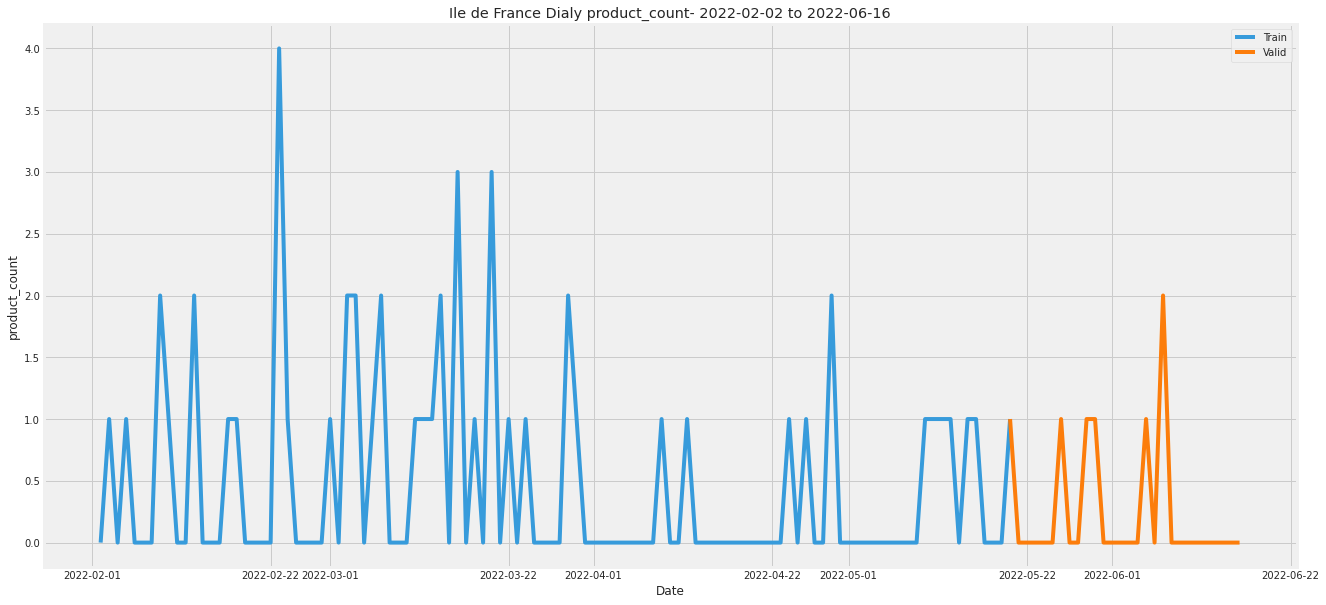

In [127]:
import pmdarima as pm
train=df_q.loc[:datetime.date(2022,5,20)]
valid=df_q.loc[datetime.date(2022,5,20):]

plt.figure(figsize=(20,10))
plt.title("Ile de France Dialy product_count- 2022-02-02 to 2022-06-16")
plt.plot(train.index, train['product_count'], color='#379BDB', label='Train')
plt.plot(valid.index, valid['product_count'], color='#fc7d0b', label='Valid')
plt.xlabel('Date')
plt.ylabel('product_count')
plt.legend()
plt.show(block=False)

In [128]:
SARIMA_model = pm.auto_arima(train['product_count'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #annual frequency(12 for month, 7 for week etc) 
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

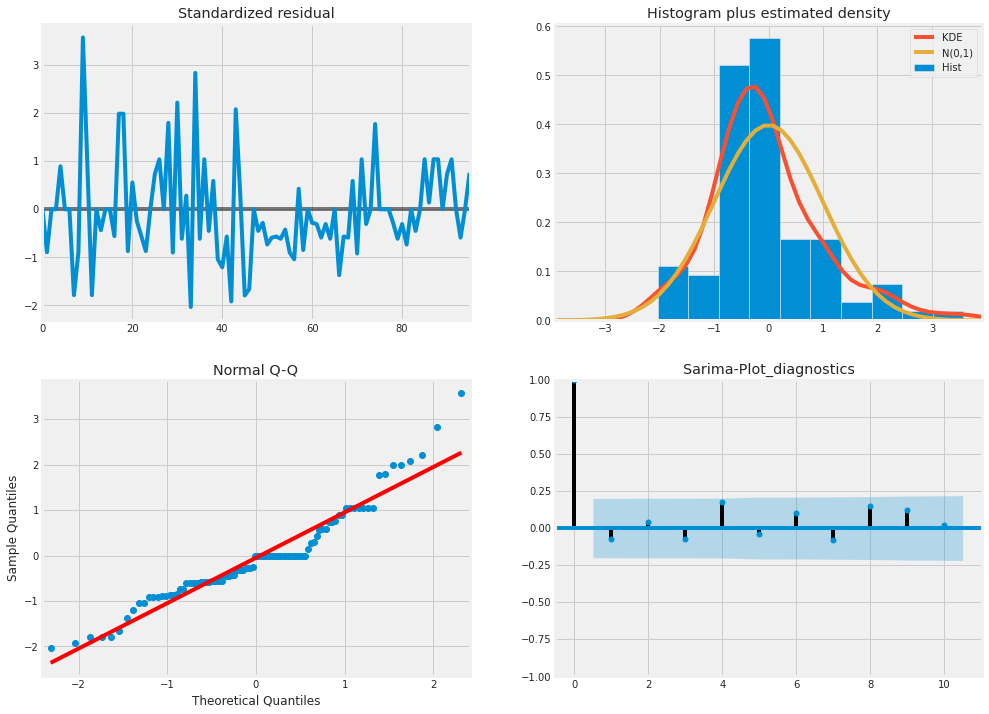

In [129]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.title('Sarima-Plot_diagnostics')
plt.savefig('Sarima_plot_diagnostics.pdf')
plt.show()

The cell above gives us the optimal order, and seasonal order to fit our ARIMA model with. In the following cell we do just that, and iteratively make 1-step predictions on the validation dataset.

In [130]:
%%time

sarima_preds = []
#df_sp.index = df_sp.index.to_period('M') 

for i in range(len(valid)):
    m_sarima = ARIMA(df_q[:len(train)+i]['product_count'], order=(0, 0, 0), seasonal_order=(2, 1, 0, 12)).fit()
    sarima_preds.append(m_sarima.forecast(1).values[0])
    
residuals = sorted([x - y for x, y in zip(sarima_preds, valid['product_count'].values)])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, f

CPU times: user 4.64 s, sys: 3.4 s, total: 8.05 s
Wall time: 4.21 s


#### Prediction Intervals

Now we have a set of predictions we can build a prediction interval.

The first step will be to choose the degree of confidence that we want to provide. Do we want our prediction to fall within the prediction interval 75%, 95%, or 99% of the time? We will use a prediction interval of 95%. In a normal distribution, 95% of data points fall within 1.96 standard deviations of the mean, so we multiply 1.96 by the RMSFE to get the prediction interval size.

##### Method 1: RMSFE

The first method that we can use is called RMSFE(root mean squared forecasting error). RMSFE is very similar to RMSE. The only difference is that RMSFE has to be calculated on residual terms from predictions on unseen data (ie. Validation or Test set).

we can only use this method if we assume that the residuals of our validation predictions are normally distributed. To see if this is the case, we will use a PP-plot (Probability-to-Probability) and test its normality with the Anderson-Darling, Kolmogorov-Smirnov, and D’Agostino K^2 tests.

The PP-plot(Probability-to-Probability) plots the data sample against the normal distribution plot in such a way that if normally distributed, the data points will form a straight line.

The three normality tests determine how likely a data sample is from a normally distributed population using p-values. The null hypothesis for each test is that "the sample came from a normally distributed population". This means that if the resulting p-values are below a chosen alpha value, then the null hypothesis is rejected. Thus there is evidence to suggest that the data comes from a non-normal distribution. We will use an Alpha value of 0.01.

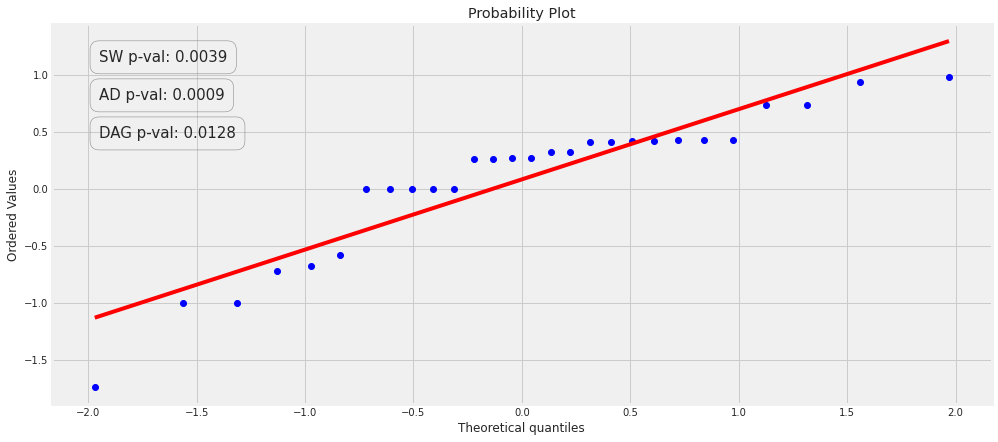

In [131]:
sw_result = stats.shapiro(residuals)
ad_result = normal_ad(np.array(residuals), axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

Not Good! Not All these three tests returned a p-value greater than the alpha value of 0.01. That means that the null hypothesis can be rejected and it is likely that the data points don't come from a normal distribution. So We can't use RMSFE to generate prediction intervals on our forecast.

#### Method 2: BCVR (Bootstrapping Cross-Validation Residuals)

 BCVR is an attempt to reap the benefits of both cross-validation and bootstrapping. Bootstrapping residuals is a common way to generate prediction intervals, and typically yields similar results to the RMSFE method with normally distributed residuals, but performs slightly better than RMSFE on non-normal residuals. Futhermore, by using cross-validation, BCVR should generate a residual distribution that is more representative of the entire dataset.

We can start by performing cross-validation to generate residuals. We randomly select a training sample that is between 95 and 110 points long and make a one-step forecast. Then, we calculate the residual for this prediction and repeat the process 1000 times.

In [132]:
%%time

crossval_count = 1000
min_size = 100
max_random = len(df_q) - (min_size)

crossval_resids = []

for b in range(crossval_count):
    start, end = [min_size*i+x for i, x in enumerate(sorted([np.random.randint(max_random) for y in range(2)]))]
    
    m_sarima = ARIMA(df_q[start:end]['product_count'], order=(0,0,0), seasonal_order=(2, 1, 0, 12), enforce_invertibility=False).fit()
    pred = m_sarima.forecast(1).values[0]
    crossval_resids.append(pred - df_q[end:end+1]['product_count'].values[0])
    
bsed_residuals = sorted(crossval_resids)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred fr

CPU times: user 2min 57s, sys: 2min 11s, total: 5min 8s
Wall time: 2min 44s


Then, we can test the normality of the residual distribution.

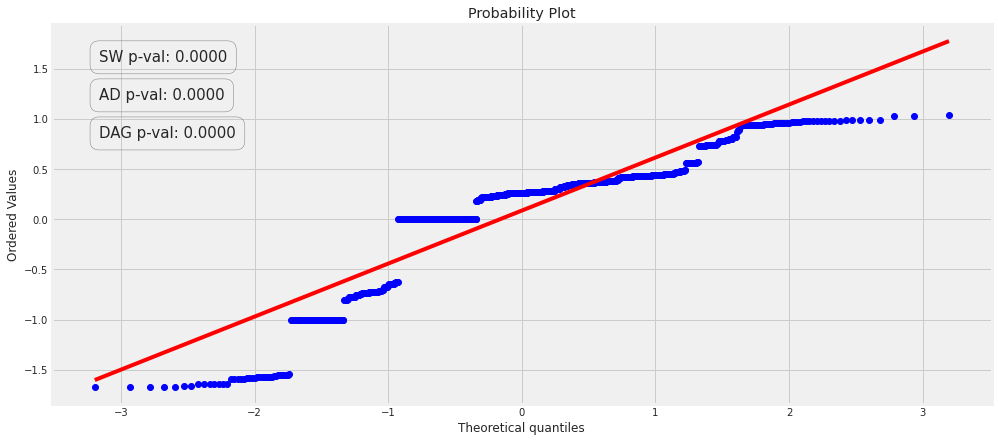

In [133]:
sw_result = stats.shapiro(bsed_residuals)
ad_result = normal_ad(np.array(bsed_residuals), axis=0)
dag_result = stats.normaltest(bsed_residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(bsed_residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

We have p-values that fall below the Alpha threshold so should reject the null hypothesis? No. We can use a technique called bootstrapping to get a measure of the residual variance. To do this, we take the cross-validated residuals and perform random sampling with replacement. We then compute the standard deviation of the resampled set and store this in an array. We repeat this process several times, and then take the mean/median of the stored bootstrapped standard deviations.

How many times one should bootstrap? here we use an early stopping to reduce computation demand. In the following implementation, we check the mean standard deviation of the bootstrapped samples every 200 iterations. If the mean standard deviation does not deviate by more than 0.1% from its value, then we terminate the loop. This is shown in the cell below.

Early Stopping Iteration: 1500
Median of Bootstrapped STD's: 0.5741


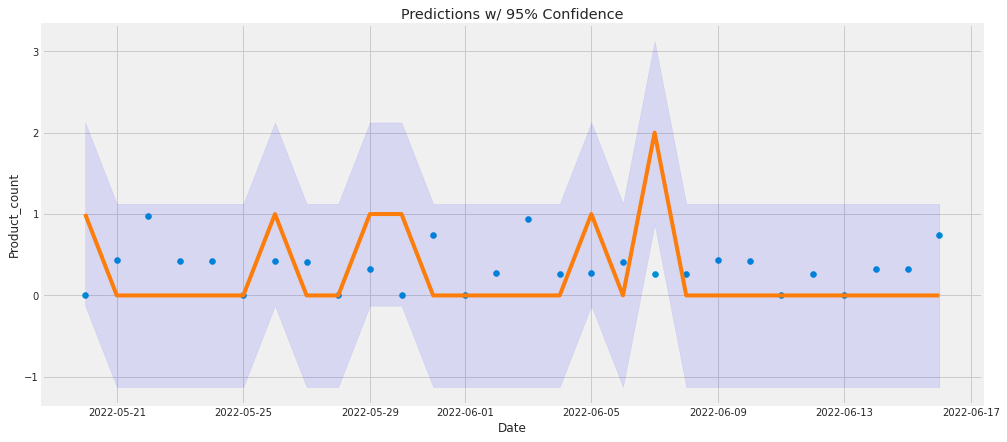

In [134]:
bs_stds=[]
last_std = None

for i in range(10000):
    samples = [bsed_residuals[np.random.randint(len(bsed_residuals))] for x in range(len(bsed_residuals))]
    bs_stds.append(np.std(samples))
    if i%500 == 0 and i!=0:
        if i == 500:
            last_std = np.median(bs_stds)
        else:
            current_std = np.median(bs_stds)
            if abs(current_std - last_std) < last_std*0.00001:
                print("Early Stopping Iteration: {}".format(i))
                break
            else:
                last_std = np.median(bs_stds)        
    
bs_std = np.median(bs_stds)
print("Median of Bootstrapped STD's: {:.4f}".format(bs_std))

bs_band_size = 1.96*bs_std 

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['product_count'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, sarima_preds)
ax.fill_between(valid.index, (valid['product_count']-bs_band_size), (valid['product_count']+bs_band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Product_count')
plt.show()

In [135]:
bs_band_size = 1.96*bs_std 
def forecast(SARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = SARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_q.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(20,10))

    plt.plot(valid.index, valid['product_count'], color='#fc7d0b', label='Valid')
    plt.scatter(valid.index, sarima_preds)
    plt.fill_between(valid.index, (valid['product_count']-bs_band_size), (valid['product_count']+bs_band_size), color='b', alpha=.1)

    plt.plot(train["product_count"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Product_Count")
    plt.savefig('Sarima_plot.pdf')
    plt.show()


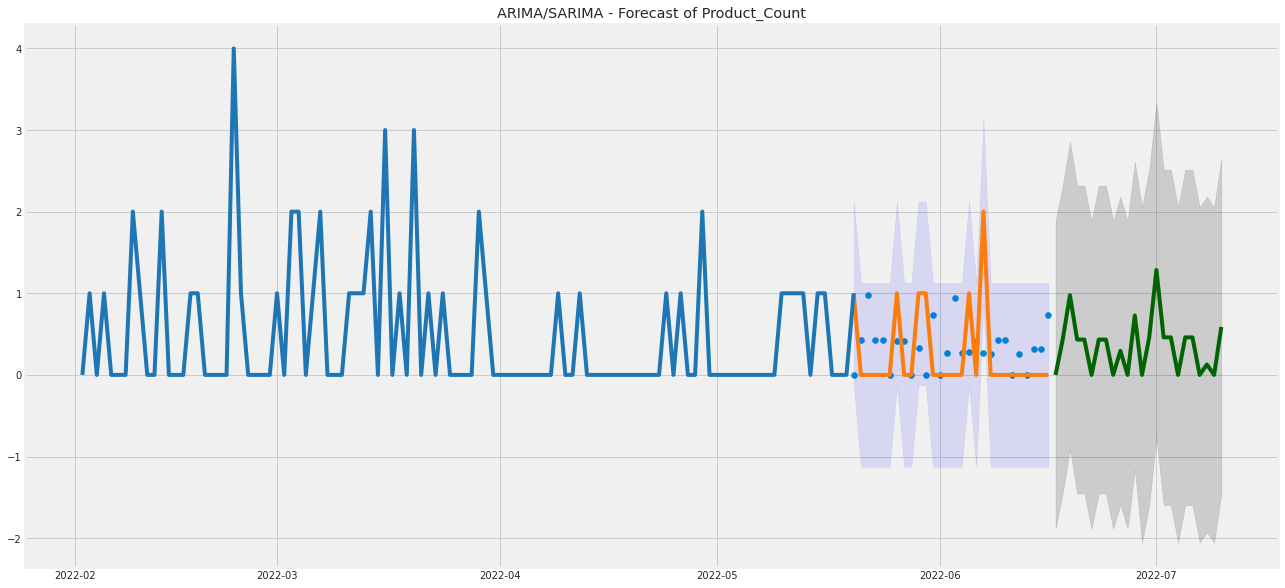

In [136]:
forecast(SARIMA_model, periods=24)

##### Métriques/score? Sur la validation.

In [137]:
print(valid.shape)
sarima_preds=array(sarima_preds).reshape(valid.shape)
sarima_preds.shape

(28, 1)


(28, 1)

In [138]:
err11=metrics_(valid,sarima_preds)
metrics_hist11=pd.DataFrame([err11])

metrics_hist11['Model']='Sarima'
metrics_hist11.set_index('Model', inplace = True)

metrics_hist11

MSE       MAE      MSLE
Model                               
Sarima  0.392443  0.491587  0.176947

#### Time Series Analysis and Forecasting with Prophet

Forecasting for the next 5 weeks for the first store!

The Prophet library is an open-source library developed by Facebook and designed for automatic forecasting of time series data. This model mainly focuses on predicting trends and seasonality.

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called Prophet. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing automated forecasting which are already implemented in R at scale in Python 3.

In [139]:
# importing Prophet model
# importing prophet library
import fbprophet
from fbprophet import Prophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [142]:
sales=df_q.copy()
sales=sales.reset_index()
sales = sales.rename(columns = {'date': 'ds',
                                'product_count': 'y'})


In [144]:
sales

ds    y
0   2022-02-02  0.0
1   2022-02-03  1.0
2   2022-02-04  0.0
3   2022-02-05  1.0
4   2022-02-06  0.0
..         ...  ...
130 2022-06-12  0.0
131 2022-06-13  0.0
132 2022-06-14  0.0
133 2022-06-15  0.0
134 2022-06-16  0.0

[135 rows x 2 columns]

In [145]:
# Next is to split the data as usual
size = int(len(sales) * 0.8)
train, test = sales[0:size], sales[size:]

In [146]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95)
my_model.fit(sales)

# dataframe that extends into future 5 weeks
future_dates = my_model.make_future_dataframe(periods = 5*7)

print("First week to forecast.")
future_dates.tail(7)
# predictions - takes around ~ 2 min to run
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


ds      yhat  yhat_lower  yhat_upper
163 2022-07-15  0.106971   -1.423215    1.503663
164 2022-07-16 -0.208186   -1.599813    1.244179
165 2022-07-17  0.212838   -1.175933    1.681095
166 2022-07-18 -0.049716   -1.446178    1.445994
167 2022-07-19  0.108395   -1.383439    1.543451
168 2022-07-20  0.169886   -1.310163    1.624021
169 2022-07-21  0.070271   -1.425757    1.606760

In [147]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions)

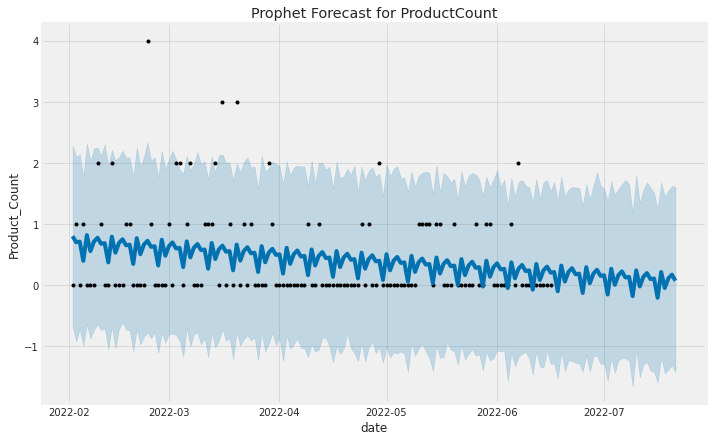

In [148]:
my_model.plot(forecast)
plt.title('Prophet Forecast for ProductCount')
plt.ylabel('Product_Count')
plt.xlabel('date')
plt.savefig('Prophet_plot.pdf')
plt.show()

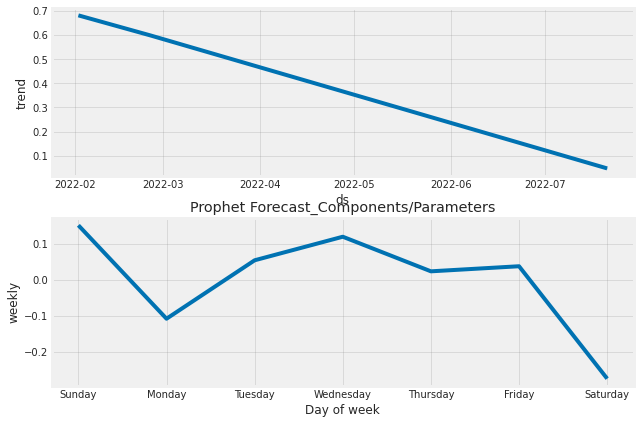

In [150]:
my_model.plot_components(forecast)
plt.title('Prophet Forecast_Components/Parameters')
plt.savefig('Prophet_Components-Parameters_plot.pdf')

###### Evaluation

In [153]:
# frequency is a day and periods are length of test data
future = my_model.make_future_dataframe(periods=len(test), freq='D')
forecasting = my_model.predict(future) 
# prediction is stored and RMSE is returned
y_true = test['y'].values
y_pred = forecasting.yhat.values[-len(test):]

errProphet=metrics_(y_true,y_pred)
metrics_hist13=pd.DataFrame([errProphet])
metrics_hist13['Model']='Prophet'
metrics_hist13.set_index('Model', inplace = True)

metrics_hist13

MSE       MAE      MSLE
Model                                
Prophet  0.309907  0.349487  0.104881

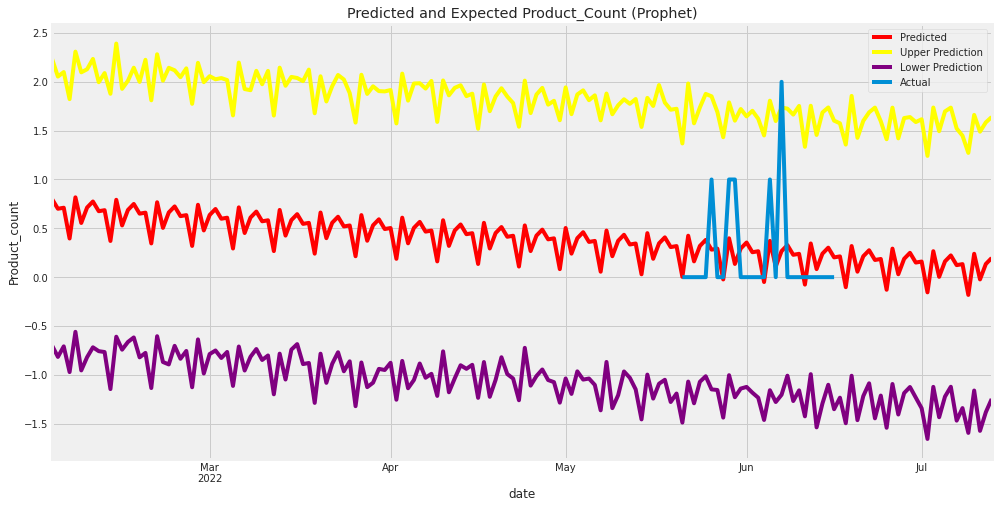

In [154]:
# Plotting forecast with test data
ax = forecasting.plot(x='ds', y='yhat', legend=True, label="Predicted", figsize=(15,8), color='red')
forecasting.plot(x='ds', y='yhat_upper', legend=True, label='Upper Prediction', ax=ax, color='yellow')
forecasting.plot(x='ds', y='yhat_lower', legend=True, label='Lower Prediction', ax=ax, color='purple')
test.plot(x='ds', y='y', legend=True, label='Actual', ax=ax)
plt.ylabel('Product_count')
plt.xlabel('date')
plt.title('Predicted and Expected Product_Count (Prophet)')
plt.legend(loc='best')
plt.show()

#### NeuralProphet

In [156]:
!pip install neuralprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 74 kB 1.6 MB/s 
     |████████████████████████████████| 179 kB 8.7 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2


In [158]:
from neuralprophet import NeuralProphet
modelNP = NeuralProphet()
df_train, df_test = modelNP.split_df(sales, valid_p=0.2)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.259% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.259% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D


In [159]:
# evaluate while training
metrics = modelNP.fit(df_train,freq='D', validation_df=df_test)

metrics

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.074% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.074% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True

  0%|          | 0/107 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.92E-01, min: 2.44E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.92E-01, min: 2.44E+00


  0%|          | 0/107 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.92E-01, min: 2.44E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.92E-01, min: 2.44E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.54E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.54E-01
Epoch[514/514]: 100%|██████████| 514/514 [00:15<00:00, 32.31it/s, SmoothL1Loss=0.0641, MAE=0.547, RMSE=0.699, RegLoss=0, MAE_val=0.677, RMSE_val=0.722, SmoothL1Loss_val=0.0652]


SmoothL1Loss       MAE      RMSE  RegLoss  SmoothL1Loss_val   MAE_val  \
0        1.670426  4.269548  4.880344      0.0          2.593188  6.186197   
1        1.648725  4.225104  4.846905      0.0          2.558736  6.117172   
2        1.627981  4.182377  4.777470      0.0          2.522587  6.044705   
3        1.605940  4.136878  4.762981      0.0          2.484803  5.968909   
4        1.582426  4.088173  4.711523      0.0          2.444301  5.887621   
..            ...       ...       ...      ...               ...       ...   
509      0.064144  0.547110  0.704558      0.0          0.065197  0.676706   
510      0.064143  0.547108  0.712565      0.0          0.065194  0.676695   
511      0.064143  0.547107  0.701896      0.0          0.065195  0.676699   
512      0.064142  0.547108  0.699701      0.0          0.065196  0.676701   
513      0.064142  0.547108  0.698515      0.0          0.065196  0.676701   

     RMSE_val  
0    6.670808  
1    6.601814  
2    6.530046  
3    6.454882  
4    6.374201  
..        ...  
509  0.722202  
510  0.722185  
511  0.722192  
512  0.722194  
513  0.722195  

[514 rows x 7 columns]

Forecast into the unknown future, extend the dataframe before predicting:



INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.074% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.074% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.143% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 97.143% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.143% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 97.143% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


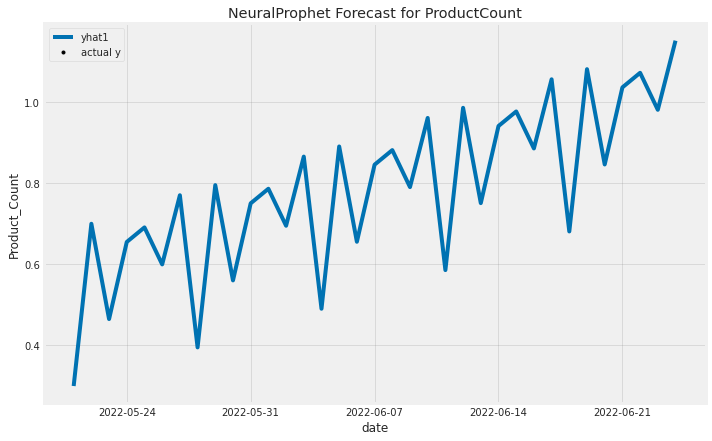

In [161]:
df_future = modelNP.make_future_dataframe(df_train, periods=35)
forecast = modelNP.predict(df_future)
fig_forecast = modelNP.plot(forecast)

plt.title('NeuralProphet Forecast for ProductCount')
plt.ylabel('Product_Count')
plt.xlabel('date')
plt.savefig('NeuralProphet_plot.pdf')
plt.show()

Visualize the results with the inbuilt plotting functions:

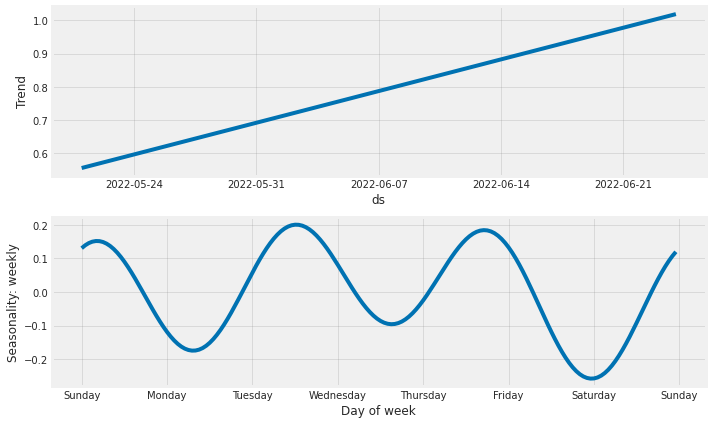

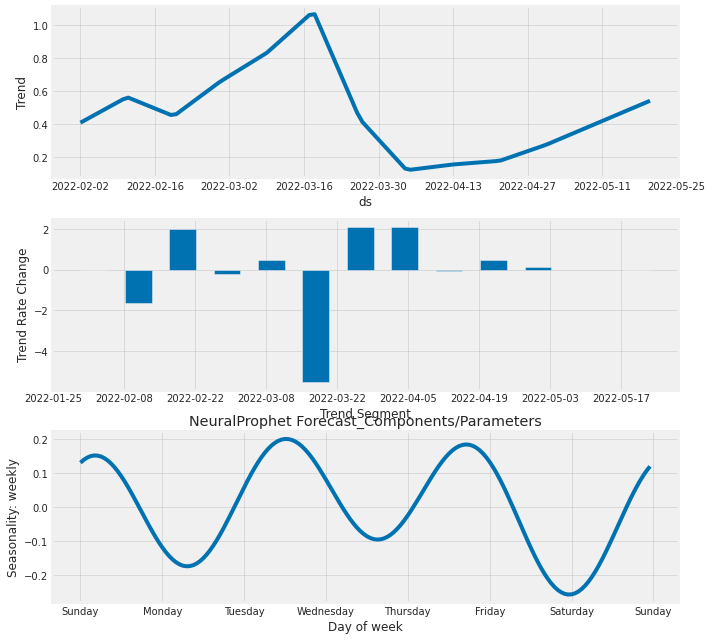

In [163]:
fig_components = modelNP.plot_components(forecast)
fig_param = modelNP.plot_parameters()
plt.title('NeuralProphet Forecast_Components/Parameters')
plt.savefig('NeuralProphet_Components-Parameters_plot.pdf')

###### Evaluation

In [167]:
# frequency is a day and periods are length of test data
future = modelNP.make_future_dataframe(df_train, periods=len(df_test))
forecasting = modelNP.predict(future) 
# prediction is stored and RMSE is returned
y_true = df_test['y'].values
y_pred = forecasting.yhat1.values[-len(df_test):]

errNProphet=metrics_(y_true,y_pred)
metrics_hist14=pd.DataFrame([errNProphet])
metrics_hist14['Model']='NeuralProphet'
metrics_hist14.set_index('Model', inplace = True)

metrics_hist14

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.074% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.074% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.296% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.296% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.296% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 96.296% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


MSE       MAE      MSLE
Model                                      
NeuralProphet  0.521565  0.676701  0.260783

#### Summary

In [198]:
frames=(metrics_hist15,metrics_hist,metrics_hist12,metrics_hist3,metrics_hist4,metrics_hist11,metric_l,metrics_hist6,metrics_hist9,metrics_hist10,metrics_hist8,metrics_hist7,metrics_hist13,metrics_hist14)
m_all= pd.concat(frames).reset_index()
m_all

Model       MSE       MAE      MSLE
0                S.Average  0.311858  0.522596  0.156173
1   Xgboost_roll(daybyday)  0.337735  0.535137  0.161505
2       XtremeGradBoosting  0.185534  0.326580  0.079107
3            Rolling or MA  0.582741  0.568148  0.194343
4                    Arima  0.314126  0.525374  0.157654
5                   Sarima  0.392443  0.491587  0.176947
6          LinearRgression  0.231455  0.373122  0.099485
7              Rand_Forest  0.224834  0.377911  0.097590
8       SimpleExpSmoothing  0.253642  0.447524  0.118435
9       DoubleExpSmoothing  0.403778  0.384031  0.161938
10                 MLP-ANN  0.522334  0.564940  0.193966
11                LSTM-ANN  0.319436  0.454230  0.129314
12                 Prophet  0.309907  0.349487  0.104881
13           NeuralProphet  0.521565  0.676701  0.260783

In [199]:
m_all=m_all.sort_values(by=['MSE','MAE','MSLE'], ascending=True)
m_all

Model       MSE       MAE      MSLE
2       XtremeGradBoosting  0.185534  0.326580  0.079107
7              Rand_Forest  0.224834  0.377911  0.097590
6          LinearRgression  0.231455  0.373122  0.099485
8       SimpleExpSmoothing  0.253642  0.447524  0.118435
12                 Prophet  0.309907  0.349487  0.104881
0                S.Average  0.311858  0.522596  0.156173
4                    Arima  0.314126  0.525374  0.157654
11                LSTM-ANN  0.319436  0.454230  0.129314
1   Xgboost_roll(daybyday)  0.337735  0.535137  0.161505
5                   Sarima  0.392443  0.491587  0.176947
9       DoubleExpSmoothing  0.403778  0.384031  0.161938
13           NeuralProphet  0.521565  0.676701  0.260783
10                 MLP-ANN  0.522334  0.564940  0.193966
3            Rolling or MA  0.582741  0.568148  0.194343

In [200]:
m_all=m_all.set_index('Model')
m_all

MSE       MAE      MSLE
Model                                               
XtremeGradBoosting      0.185534  0.326580  0.079107
Rand_Forest             0.224834  0.377911  0.097590
LinearRgression         0.231455  0.373122  0.099485
SimpleExpSmoothing      0.253642  0.447524  0.118435
Prophet                 0.309907  0.349487  0.104881
S.Average               0.311858  0.522596  0.156173
Arima                   0.314126  0.525374  0.157654
LSTM-ANN                0.319436  0.454230  0.129314
Xgboost_roll(daybyday)  0.337735  0.535137  0.161505
Sarima                  0.392443  0.491587  0.176947
DoubleExpSmoothing      0.403778  0.384031  0.161938
NeuralProphet           0.521565  0.676701  0.260783
MLP-ANN                 0.522334  0.564940  0.193966
Rolling or MA           0.582741  0.568148  0.194343

In [201]:
m_all.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &       MSE &       MAE &      MSLE \\\\\nModel                  &           &           &           \\\\\n\\midrule\nXtremeGradBoosting     &  0.185534 &  0.326580 &  0.079107 \\\\\nRand\\_Forest            &  0.224834 &  0.377911 &  0.097590 \\\\\nLinearRgression        &  0.231455 &  0.373122 &  0.099485 \\\\\nSimpleExpSmoothing     &  0.253642 &  0.447524 &  0.118435 \\\\\nProphet                &  0.309907 &  0.349487 &  0.104881 \\\\\nS.Average              &  0.311858 &  0.522596 &  0.156173 \\\\\nArima                  &  0.314126 &  0.525374 &  0.157654 \\\\\nLSTM-ANN               &  0.319436 &  0.454230 &  0.129314 \\\\\nXgboost\\_roll(daybyday) &  0.337735 &  0.535137 &  0.161505 \\\\\nSarima                 &  0.392443 &  0.491587 &  0.176947 \\\\\nDoubleExpSmoothing     &  0.403778 &  0.384031 &  0.161938 \\\\\nNeuralProphet          &  0.521565 &  0.676701 &  0.260783 \\\\\nMLP-ANN                &  0.522334 &  0.564940 &  0.193966 

#### Final graph for the RMSE's of each model

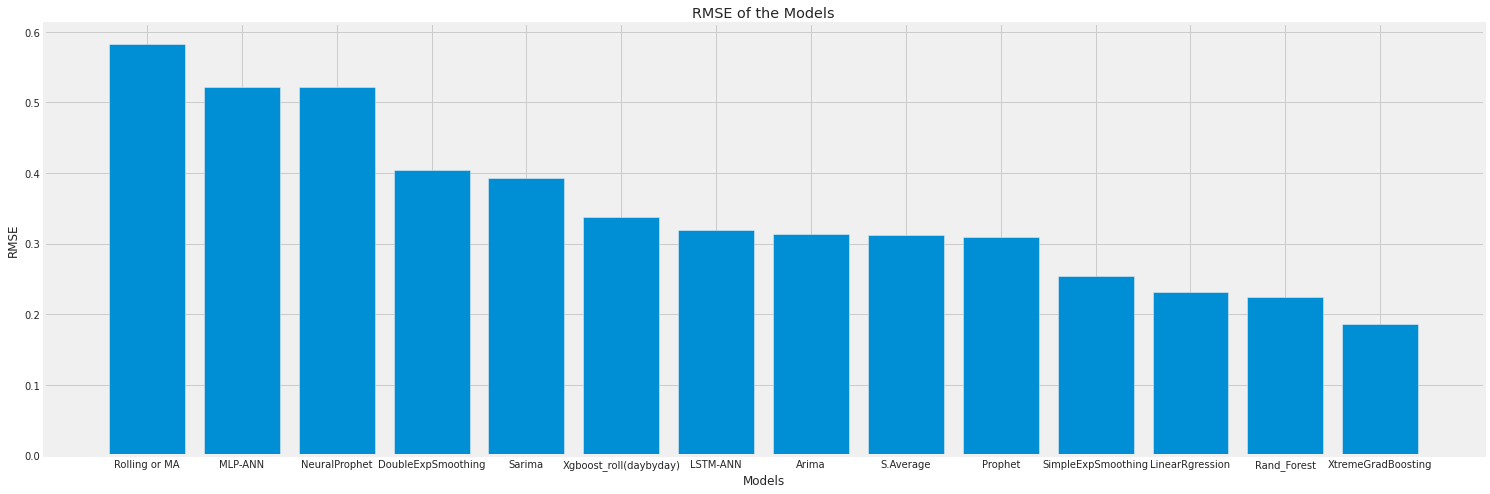

In [203]:
models=m_all.sort_values(by=['MSE','MAE','MSLE'], ascending=False)
fig = plt.figure(figsize=(20,6))
ax = fig.add_axes([0,0,1,1])
modelz = models.index # or models['Model]
nums = models.MSE # or models['MSE]
ax.bar(modelz,nums)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of the Models')
plt.savefig('Summary_plot.pdf')